copy from https://www.tensorflow.org/tutorials/structured_data/time_series?hl=ko

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single timestep:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

    8192/13568290 [..............................] - ETA: 0s

 4202496/13568290 [========>.....................] - ETA: 0s

13574144/13568290 [==============================] - 0s 0us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h:

In [ ]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

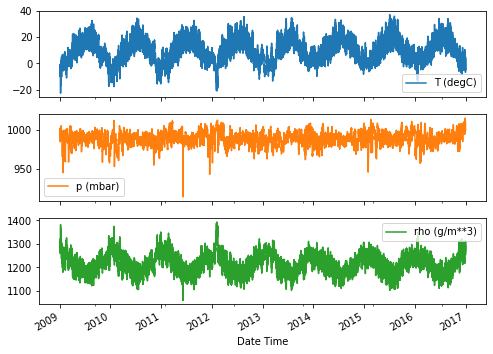

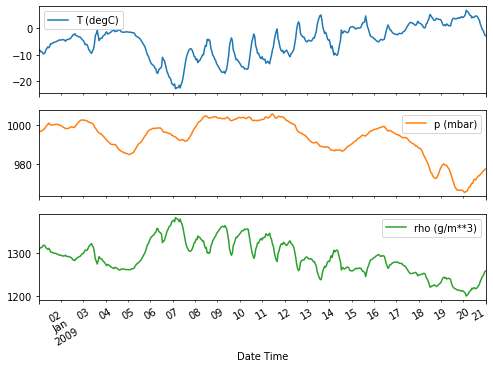

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

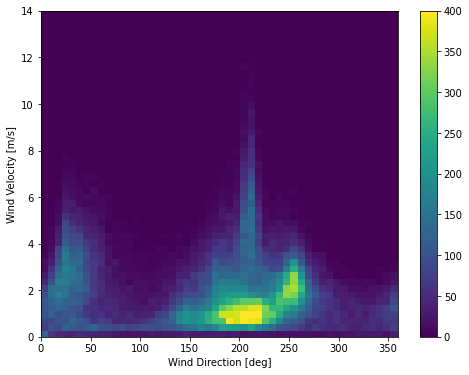

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

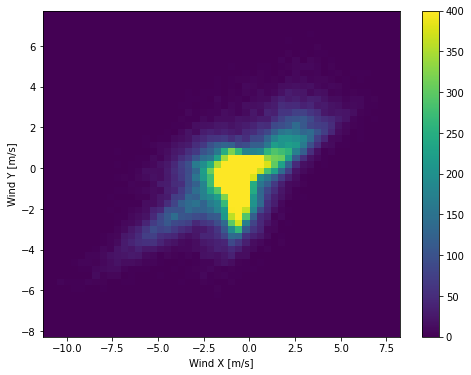

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

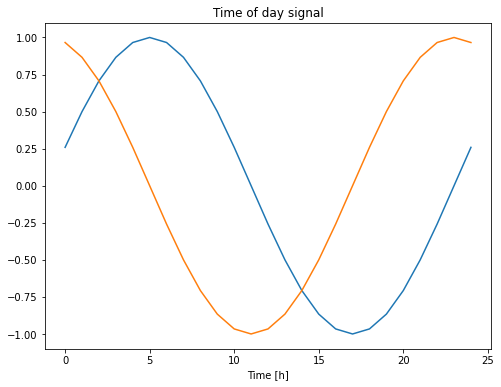

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

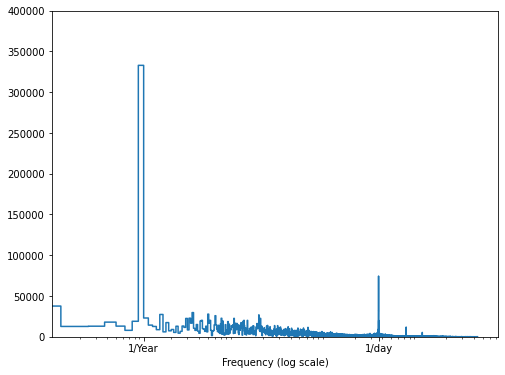

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

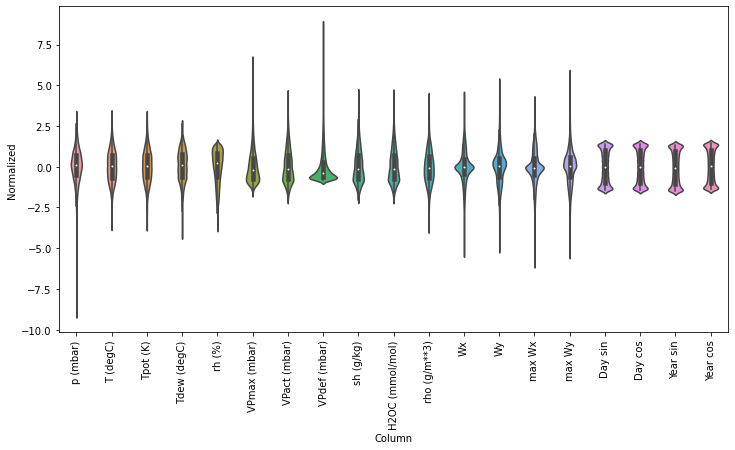

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](images/raw_window_24h.png)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecuitive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

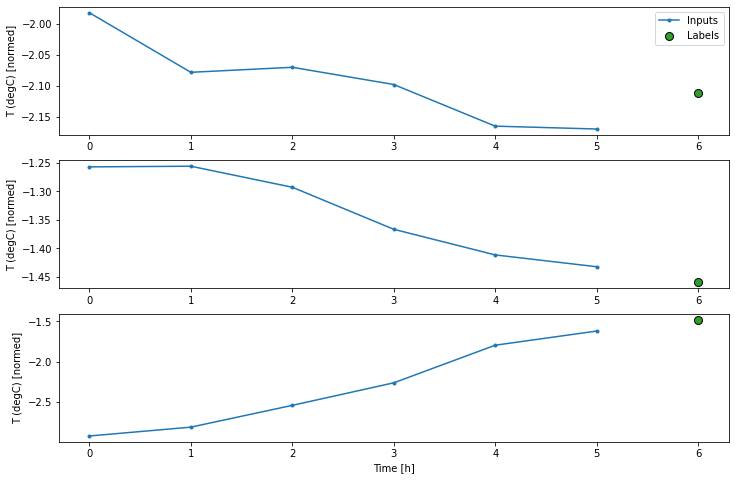

In [ ]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

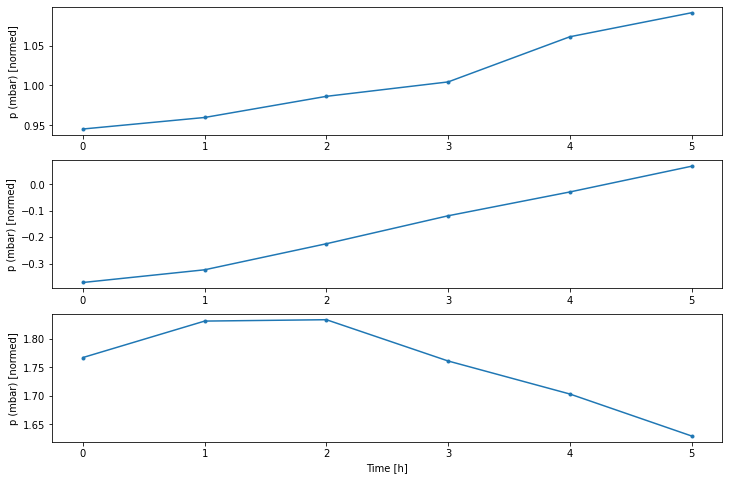

In [ ]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the `T (degC)` value 1h into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature. 

So start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [ ]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0635

 24/439 [>.............................] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0824

 48/439 [==>...........................] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0802

 72/439 [===>..........................] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0784

 95/439 [=====>........................] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0791

119/439 [=======>......................] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0793

142/439 [========>.....................] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0789

166/439 [==========>...................] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0792

190/439 [===========>..................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0793

214/439 [=============>................] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0790

237/439 [===============>..............] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

260/439 [================>.............] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0785

284/439 [==================>...........] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0786

307/439 [===================>..........] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0786

330/439 [=====================>........] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0788

354/439 [=======================>......] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0785

377/439 [========================>.....] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0785

400/439 [==========================>...] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0784

423/439 [===========================>..] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0784

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time. 

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:

  ![One prediction 1h into the future, ever hour.](images/last_window.png)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

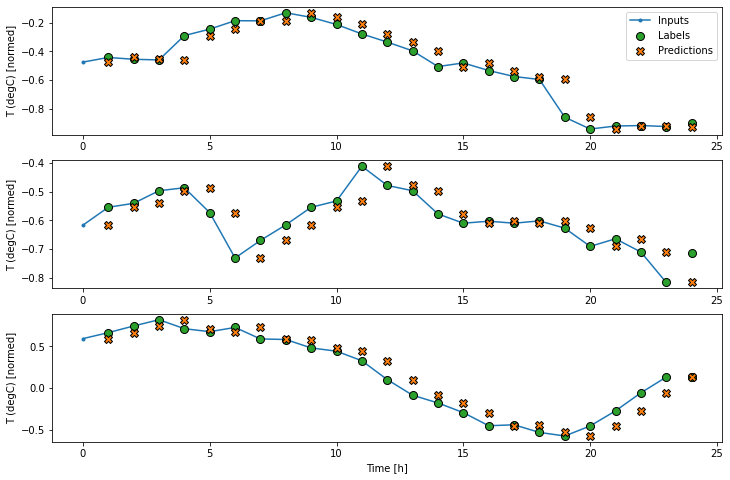

In [ ]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24h. This deserves some explaination:

* The blue "Inputs" line shows the input temperature at each time step. The model recieves all features, this plot only shows the temperature.
* The green "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)


Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 0s - loss: 4.5335 - mean_absolute_error: 1.6435

  20/1534 [..............................] - ETA: 3s - loss: 3.8090 - mean_absolute_error: 1.5812

  40/1534 [..............................] - ETA: 3s - loss: 3.5219 - mean_absolute_error: 1.5064

  60/1534 [>.............................] - ETA: 3s - loss: 3.2373 - mean_absolute_error: 1.4433

  80/1534 [>.............................] - ETA: 3s - loss: 2.9373 - mean_absolute_error: 1.3719

 100/1534 [>.............................] - ETA: 3s - loss: 2.6552 - mean_absolute_error: 1.2983

 120/1534 [=>............................] - ETA: 3s - loss: 2.4367 - mean_absolute_error: 1.2366

 139/1534 [=>............................] - ETA: 3s - loss: 2.2464 - mean_absolute_error: 1.1802

 159/1534 [==>...........................] - ETA: 3s - loss: 2.0640 - mean_absolute_error: 1.1210

 178/1534 [==>...........................] - ETA: 3s - loss: 1.9174 - mean_absolute_error: 1.0740

 197/1534 [==>...........................] - ETA: 3s - loss: 1.7897 - mean_absolute_error: 1.0299

 216/1534 [===>..........................] - ETA: 3s - loss: 1.6776 - mean_absolute_error: 0.9903

 236/1534 [===>..........................] - ETA: 3s - loss: 1.5681 - mean_absolute_error: 0.9493

 256/1534 [====>.........................] - ETA: 3s - loss: 1.4702 - mean_absolute_error: 0.9096

 276/1534 [====>.........................] - ETA: 3s - loss: 1.3843 - mean_absolute_error: 0.8744

 296/1534 [====>.........................] - ETA: 3s - loss: 1.3061 - mean_absolute_error: 0.8411

 315/1534 [=====>........................] - ETA: 3s - loss: 1.2395 - mean_absolute_error: 0.8121

 335/1534 [=====>........................] - ETA: 3s - loss: 1.1757 - mean_absolute_error: 0.7833

 355/1534 [=====>........................] - ETA: 3s - loss: 1.1174 - mean_absolute_error: 0.7561

 375/1534 [======>.......................] - ETA: 3s - loss: 1.0643 - mean_absolute_error: 0.7306

 395/1534 [======>.......................] - ETA: 2s - loss: 1.0162 - mean_absolute_error: 0.7075

 415/1534 [=======>......................] - ETA: 2s - loss: 0.9722 - mean_absolute_error: 0.6858

 435/1534 [=======>......................] - ETA: 2s - loss: 0.9318 - mean_absolute_error: 0.6657

 455/1534 [=======>......................] - ETA: 2s - loss: 0.8946 - mean_absolute_error: 0.6467

 476/1534 [========>.....................] - ETA: 2s - loss: 0.8587 - mean_absolute_error: 0.6282

 496/1534 [========>.....................] - ETA: 2s - loss: 0.8270 - mean_absolute_error: 0.6118

 515/1534 [=========>....................] - ETA: 2s - loss: 0.7988 - mean_absolute_error: 0.5966

 534/1534 [=========>....................] - ETA: 2s - loss: 0.7728 - mean_absolute_error: 0.5828

 553/1534 [=========>....................] - ETA: 2s - loss: 0.7482 - mean_absolute_error: 0.5695

 572/1534 [==========>...................] - ETA: 2s - loss: 0.7251 - mean_absolute_error: 0.5567

 592/1534 [==========>...................] - ETA: 2s - loss: 0.7023 - mean_absolute_error: 0.5440

 612/1534 [==========>...................] - ETA: 2s - loss: 0.6809 - mean_absolute_error: 0.5318

 632/1534 [===========>..................] - ETA: 2s - loss: 0.6607 - mean_absolute_error: 0.5202

 652/1534 [===========>..................] - ETA: 2s - loss: 0.6417 - mean_absolute_error: 0.5093

 671/1534 [============>.................] - ETA: 2s - loss: 0.6246 - mean_absolute_error: 0.4994

 691/1534 [============>.................] - ETA: 2s - loss: 0.6076 - mean_absolute_error: 0.4891

 710/1534 [============>.................] - ETA: 2s - loss: 0.5924 - mean_absolute_error: 0.4803

 729/1534 [=============>................] - ETA: 2s - loss: 0.5779 - mean_absolute_error: 0.4717

 748/1534 [=============>................] - ETA: 2s - loss: 0.5641 - mean_absolute_error: 0.4634

 768/1534 [==============>...............] - ETA: 1s - loss: 0.5502 - mean_absolute_error: 0.4551

 785/1534 [==============>...............] - ETA: 1s - loss: 0.5389 - mean_absolute_error: 0.4482

 805/1534 [==============>...............] - ETA: 1s - loss: 0.5264 - mean_absolute_error: 0.4406

 825/1534 [===============>..............] - ETA: 1s - loss: 0.5144 - mean_absolute_error: 0.4334

 844/1534 [===============>..............] - ETA: 1s - loss: 0.5034 - mean_absolute_error: 0.4265

 863/1534 [===============>..............] - ETA: 1s - loss: 0.4930 - mean_absolute_error: 0.4201

 883/1534 [================>.............] - ETA: 1s - loss: 0.4824 - mean_absolute_error: 0.4136

 902/1534 [================>.............] - ETA: 1s - loss: 0.4729 - mean_absolute_error: 0.4077

 922/1534 [=================>............] - ETA: 1s - loss: 0.4632 - mean_absolute_error: 0.4017

 942/1534 [=================>............] - ETA: 1s - loss: 0.4539 - mean_absolute_error: 0.3958

 962/1534 [=================>............] - ETA: 1s - loss: 0.4451 - mean_absolute_error: 0.3904

 983/1534 [==================>...........] - ETA: 1s - loss: 0.4361 - mean_absolute_error: 0.3846

1003/1534 [==================>...........] - ETA: 1s - loss: 0.4279 - mean_absolute_error: 0.3794

1023/1534 [===================>..........] - ETA: 1s - loss: 0.4200 - mean_absolute_error: 0.3744

1043/1534 [===================>..........] - ETA: 1s - loss: 0.4124 - mean_absolute_error: 0.3695

1063/1534 [===================>..........] - ETA: 1s - loss: 0.4051 - mean_absolute_error: 0.3648

1082/1534 [====================>.........] - ETA: 1s - loss: 0.3984 - mean_absolute_error: 0.3604

1101/1534 [====================>.........] - ETA: 1s - loss: 0.3919 - mean_absolute_error: 0.3562

1121/1534 [====================>.........] - ETA: 1s - loss: 0.3852 - mean_absolute_error: 0.3518

1141/1534 [=====================>........] - ETA: 1s - loss: 0.3788 - mean_absolute_error: 0.3474

1160/1534 [=====================>........] - ETA: 0s - loss: 0.3729 - mean_absolute_error: 0.3436

1179/1534 [======================>.......] - ETA: 0s - loss: 0.3673 - mean_absolute_error: 0.3399

1199/1534 [======================>.......] - ETA: 0s - loss: 0.3615 - mean_absolute_error: 0.3360

1219/1534 [======================>.......] - ETA: 0s - loss: 0.3559 - mean_absolute_error: 0.3323

1239/1534 [=======================>......] - ETA: 0s - loss: 0.3505 - mean_absolute_error: 0.3287

1258/1534 [=======================>......] - ETA: 0s - loss: 0.3454 - mean_absolute_error: 0.3253

1278/1534 [=======================>......] - ETA: 0s - loss: 0.3403 - mean_absolute_error: 0.3218

1299/1534 [========================>.....] - ETA: 0s - loss: 0.3351 - mean_absolute_error: 0.3183

1320/1534 [========================>.....] - ETA: 0s - loss: 0.3301 - mean_absolute_error: 0.3149

1340/1534 [=========================>....] - ETA: 0s - loss: 0.3254 - mean_absolute_error: 0.3118

1359/1534 [=========================>....] - ETA: 0s - loss: 0.3211 - mean_absolute_error: 0.3089

1379/1534 [=========================>....] - ETA: 0s - loss: 0.3167 - mean_absolute_error: 0.3057

1399/1534 [==========================>...] - ETA: 0s - loss: 0.3124 - mean_absolute_error: 0.3028

1419/1534 [==========================>...] - ETA: 0s - loss: 0.3082 - mean_absolute_error: 0.3000

1440/1534 [===========================>..] - ETA: 0s - loss: 0.3040 - mean_absolute_error: 0.2970

1461/1534 [===========================>..] - ETA: 0s - loss: 0.2998 - mean_absolute_error: 0.2941

1481/1534 [===========================>..] - ETA: 0s - loss: 0.2960 - mean_absolute_error: 0.2915

1501/1534 [============================>.] - ETA: 0s - loss: 0.2923 - mean_absolute_error: 0.2889

1521/1534 [============================>.] - ETA: 0s - loss: 0.2886 - mean_absolute_error: 0.2863

1534/1534 [==============================] - 5s 3ms/step - loss: 0.2864 - mean_absolute_error: 0.2848 - val_loss: 0.0163 - val_mean_absolute_error: 0.0975


Epoch 2/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0160 - mean_absolute_error: 0.0866

  20/1534 [..............................] - ETA: 3s - loss: 0.0166 - mean_absolute_error: 0.0946

  39/1534 [..............................] - ETA: 3s - loss: 0.0159 - mean_absolute_error: 0.0931

  60/1534 [>.............................] - ETA: 3s - loss: 0.0153 - mean_absolute_error: 0.0918

  79/1534 [>.............................] - ETA: 3s - loss: 0.0156 - mean_absolute_error: 0.0930

  98/1534 [>.............................] - ETA: 3s - loss: 0.0151 - mean_absolute_error: 0.0922

 117/1534 [=>............................] - ETA: 3s - loss: 0.0154 - mean_absolute_error: 0.0926

 136/1534 [=>............................] - ETA: 3s - loss: 0.0152 - mean_absolute_error: 0.0925

 155/1534 [==>...........................] - ETA: 3s - loss: 0.0153 - mean_absolute_error: 0.0926

 174/1534 [==>...........................] - ETA: 3s - loss: 0.0151 - mean_absolute_error: 0.0924

 194/1534 [==>...........................] - ETA: 3s - loss: 0.0149 - mean_absolute_error: 0.0915

 214/1534 [===>..........................] - ETA: 3s - loss: 0.0149 - mean_absolute_error: 0.0914

 233/1534 [===>..........................] - ETA: 3s - loss: 0.0149 - mean_absolute_error: 0.0914

 253/1534 [===>..........................] - ETA: 3s - loss: 0.0148 - mean_absolute_error: 0.0911

 273/1534 [====>.........................] - ETA: 3s - loss: 0.0147 - mean_absolute_error: 0.0908

 292/1534 [====>.........................] - ETA: 3s - loss: 0.0146 - mean_absolute_error: 0.0901

 311/1534 [=====>........................] - ETA: 3s - loss: 0.0145 - mean_absolute_error: 0.0898

 329/1534 [=====>........................] - ETA: 3s - loss: 0.0144 - mean_absolute_error: 0.0895

 347/1534 [=====>........................] - ETA: 3s - loss: 0.0142 - mean_absolute_error: 0.0892

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0141 - mean_absolute_error: 0.0889

 386/1534 [======>.......................] - ETA: 3s - loss: 0.0141 - mean_absolute_error: 0.0887

 406/1534 [======>.......................] - ETA: 2s - loss: 0.0140 - mean_absolute_error: 0.0885

 426/1534 [=======>......................] - ETA: 2s - loss: 0.0140 - mean_absolute_error: 0.0886

 446/1534 [=======>......................] - ETA: 2s - loss: 0.0139 - mean_absolute_error: 0.0883

 466/1534 [========>.....................] - ETA: 2s - loss: 0.0139 - mean_absolute_error: 0.0881

 486/1534 [========>.....................] - ETA: 2s - loss: 0.0139 - mean_absolute_error: 0.0881

 503/1534 [========>.....................] - ETA: 2s - loss: 0.0138 - mean_absolute_error: 0.0879

 523/1534 [=========>....................] - ETA: 2s - loss: 0.0138 - mean_absolute_error: 0.0877

 543/1534 [=========>....................] - ETA: 2s - loss: 0.0138 - mean_absolute_error: 0.0876

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0137 - mean_absolute_error: 0.0873

 582/1534 [==========>...................] - ETA: 2s - loss: 0.0136 - mean_absolute_error: 0.0869

 601/1534 [==========>...................] - ETA: 2s - loss: 0.0135 - mean_absolute_error: 0.0867

 620/1534 [===========>..................] - ETA: 2s - loss: 0.0135 - mean_absolute_error: 0.0866

 639/1534 [===========>..................] - ETA: 2s - loss: 0.0134 - mean_absolute_error: 0.0864

 658/1534 [===========>..................] - ETA: 2s - loss: 0.0134 - mean_absolute_error: 0.0862

 677/1534 [============>.................] - ETA: 2s - loss: 0.0133 - mean_absolute_error: 0.0861

 696/1534 [============>.................] - ETA: 2s - loss: 0.0133 - mean_absolute_error: 0.0859

 716/1534 [=============>................] - ETA: 2s - loss: 0.0133 - mean_absolute_error: 0.0859

 736/1534 [=============>................] - ETA: 2s - loss: 0.0133 - mean_absolute_error: 0.0857

 756/1534 [=============>................] - ETA: 2s - loss: 0.0132 - mean_absolute_error: 0.0855

 775/1534 [==============>...............] - ETA: 2s - loss: 0.0131 - mean_absolute_error: 0.0853

 795/1534 [==============>...............] - ETA: 1s - loss: 0.0131 - mean_absolute_error: 0.0853

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0130 - mean_absolute_error: 0.0851

 835/1534 [===============>..............] - ETA: 1s - loss: 0.0130 - mean_absolute_error: 0.0849

 854/1534 [===============>..............] - ETA: 1s - loss: 0.0130 - mean_absolute_error: 0.0848

 874/1534 [================>.............] - ETA: 1s - loss: 0.0130 - mean_absolute_error: 0.0847

 894/1534 [================>.............] - ETA: 1s - loss: 0.0129 - mean_absolute_error: 0.0846

 913/1534 [================>.............] - ETA: 1s - loss: 0.0129 - mean_absolute_error: 0.0845

 932/1534 [=================>............] - ETA: 1s - loss: 0.0129 - mean_absolute_error: 0.0844

 951/1534 [=================>............] - ETA: 1s - loss: 0.0129 - mean_absolute_error: 0.0844

 970/1534 [=================>............] - ETA: 1s - loss: 0.0129 - mean_absolute_error: 0.0843

 989/1534 [==================>...........] - ETA: 1s - loss: 0.0128 - mean_absolute_error: 0.0841

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0128 - mean_absolute_error: 0.0840

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0129 - mean_absolute_error: 0.0841

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0128 - mean_absolute_error: 0.0840

1065/1534 [===================>..........] - ETA: 1s - loss: 0.0128 - mean_absolute_error: 0.0840

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0128 - mean_absolute_error: 0.0839

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0127 - mean_absolute_error: 0.0837

1121/1534 [====================>.........] - ETA: 1s - loss: 0.0127 - mean_absolute_error: 0.0835

1141/1534 [=====================>........] - ETA: 1s - loss: 0.0127 - mean_absolute_error: 0.0834

1160/1534 [=====================>........] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0833

1179/1534 [======================>.......] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0832

1198/1534 [======================>.......] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0832

1216/1534 [======================>.......] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0830

1236/1534 [=======================>......] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0831

1255/1534 [=======================>......] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0830

1274/1534 [=======================>......] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0829

1294/1534 [========================>.....] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0828

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0828

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0826

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0826

1373/1534 [=========================>....] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0824

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0823

1413/1534 [==========================>...] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0822

1432/1534 [===========================>..] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0822

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0821

1471/1534 [===========================>..] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0820

1492/1534 [============================>.] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0819

1512/1534 [============================>.] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0818

1534/1534 [==============================] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.0817

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0121 - mean_absolute_error: 0.0817 - val_loss: 0.0103 - val_mean_absolute_error: 0.0752


Epoch 3/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0150 - mean_absolute_error: 0.0825

  20/1534 [..............................] - ETA: 3s - loss: 0.0116 - mean_absolute_error: 0.0786

  40/1534 [..............................] - ETA: 3s - loss: 0.0117 - mean_absolute_error: 0.0783

  60/1534 [>.............................] - ETA: 3s - loss: 0.0111 - mean_absolute_error: 0.0763

  80/1534 [>.............................] - ETA: 3s - loss: 0.0111 - mean_absolute_error: 0.0769

  99/1534 [>.............................] - ETA: 3s - loss: 0.0110 - mean_absolute_error: 0.0771

 119/1534 [=>............................] - ETA: 3s - loss: 0.0110 - mean_absolute_error: 0.0773

 139/1534 [=>............................] - ETA: 3s - loss: 0.0109 - mean_absolute_error: 0.0768

 159/1534 [==>...........................] - ETA: 3s - loss: 0.0110 - mean_absolute_error: 0.0769

 178/1534 [==>...........................] - ETA: 3s - loss: 0.0108 - mean_absolute_error: 0.0766

 197/1534 [==>...........................] - ETA: 3s - loss: 0.0106 - mean_absolute_error: 0.0760

 216/1534 [===>..........................] - ETA: 3s - loss: 0.0106 - mean_absolute_error: 0.0759

 235/1534 [===>..........................] - ETA: 3s - loss: 0.0108 - mean_absolute_error: 0.0764

 255/1534 [===>..........................] - ETA: 3s - loss: 0.0107 - mean_absolute_error: 0.0762

 274/1534 [====>.........................] - ETA: 3s - loss: 0.0107 - mean_absolute_error: 0.0762

 294/1534 [====>.........................] - ETA: 3s - loss: 0.0107 - mean_absolute_error: 0.0761

 314/1534 [=====>........................] - ETA: 3s - loss: 0.0106 - mean_absolute_error: 0.0759

 334/1534 [=====>........................] - ETA: 3s - loss: 0.0106 - mean_absolute_error: 0.0758

 354/1534 [=====>........................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0755

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0754

 393/1534 [======>.......................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0754

 412/1534 [=======>......................] - ETA: 2s - loss: 0.0104 - mean_absolute_error: 0.0754

 432/1534 [=======>......................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0756

 452/1534 [=======>......................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0756

 472/1534 [========>.....................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0757

 492/1534 [========>.....................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0756

 511/1534 [========>.....................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0756

 530/1534 [=========>....................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0756

 549/1534 [=========>....................] - ETA: 2s - loss: 0.0106 - mean_absolute_error: 0.0756

 569/1534 [==========>...................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0754

 589/1534 [==========>...................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0753

 609/1534 [==========>...................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0754

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0754

 649/1534 [===========>..................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0754

 668/1534 [============>.................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0753

 687/1534 [============>.................] - ETA: 2s - loss: 0.0104 - mean_absolute_error: 0.0753

 707/1534 [============>.................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0754

 727/1534 [=============>................] - ETA: 2s - loss: 0.0105 - mean_absolute_error: 0.0753

 748/1534 [=============>................] - ETA: 2s - loss: 0.0104 - mean_absolute_error: 0.0752

 768/1534 [==============>...............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0752

 787/1534 [==============>...............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0752

 806/1534 [==============>...............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0753

 822/1534 [===============>..............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0752

 842/1534 [===============>..............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0751

 862/1534 [===============>..............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0751

 881/1534 [================>.............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0751

 901/1534 [================>.............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0751

 920/1534 [================>.............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0751

 939/1534 [=================>............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0752

 958/1534 [=================>............] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0752

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0751

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0751

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0752

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0752

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0752

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0753

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0753

1114/1534 [====================>.........] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0752

1133/1534 [=====================>........] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0751

1153/1534 [=====================>........] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0751

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0751

1192/1534 [======================>.......] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0751

1211/1534 [======================>.......] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0751

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0752

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0753

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0752

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0752

1308/1534 [========================>.....] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0752

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0751

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0751

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0751

1384/1534 [==========================>...] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0750

1403/1534 [==========================>...] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0750

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0750

1443/1534 [===========================>..] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0750

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0750

1483/1534 [============================>.] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0749

1502/1534 [============================>.] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0749

1522/1534 [============================>.] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0749

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0103 - mean_absolute_error: 0.0749 - val_loss: 0.0098 - val_mean_absolute_error: 0.0738


Epoch 4/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0883

  20/1534 [..............................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0755

  39/1534 [..............................] - ETA: 3s - loss: 0.0109 - mean_absolute_error: 0.0763

  58/1534 [>.............................] - ETA: 3s - loss: 0.0106 - mean_absolute_error: 0.0755

  77/1534 [>.............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0751

  96/1534 [>.............................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0749

 116/1534 [=>............................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0751

 136/1534 [=>............................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0750

 155/1534 [==>...........................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0750

 174/1534 [==>...........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0746

 193/1534 [==>...........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0744

 211/1534 [===>..........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0742

 230/1534 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0746

 249/1534 [===>..........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0746

 268/1534 [====>.........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0746

 288/1534 [====>.........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0743

 308/1534 [=====>........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0742

 327/1534 [=====>........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0740

 343/1534 [=====>........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0739

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0736

 382/1534 [======>.......................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0736

 402/1534 [======>.......................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0735

 422/1534 [=======>......................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0737

 442/1534 [=======>......................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0739

 463/1534 [========>.....................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0738

 483/1534 [========>.....................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0738

 503/1534 [========>.....................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0737

 524/1534 [=========>....................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0739

 544/1534 [=========>....................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0738

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0737

 584/1534 [==========>...................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0736

 603/1534 [==========>...................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0735

 622/1534 [===========>..................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0735

 642/1534 [===========>..................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0736

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0735

 680/1534 [============>.................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0736

 699/1534 [============>.................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0736

 719/1534 [=============>................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0736

 738/1534 [=============>................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0735

 757/1534 [=============>................] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0735

 777/1534 [==============>...............] - ETA: 2s - loss: 0.0100 - mean_absolute_error: 0.0735

 796/1534 [==============>...............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0735

 816/1534 [==============>...............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0735

 836/1534 [===============>..............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0734

 856/1534 [===============>..............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0734

 876/1534 [================>.............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0734

 896/1534 [================>.............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0735

 916/1534 [================>.............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0734

 936/1534 [=================>............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0735

 956/1534 [=================>............] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0735

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0735

 994/1534 [==================>...........] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0735

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0736

1033/1534 [===================>..........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0736

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0736

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0736

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0736

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0735

1130/1534 [=====================>........] - ETA: 1s - loss: 0.0101 - mean_absolute_error: 0.0735

1150/1534 [=====================>........] - ETA: 1s - loss: 0.0100 - mean_absolute_error: 0.0735

1170/1534 [=====================>........] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0735

1190/1534 [======================>.......] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0735

1210/1534 [======================>.......] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1229/1534 [=======================>......] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0735

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0737

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0737

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0736

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0736

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0736

1344/1534 [=========================>....] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0736

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0736

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1403/1534 [==========================>...] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0735

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1443/1534 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1462/1534 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1499/1534 [============================>.] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0734

1518/1534 [============================>.] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0733

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0099 - mean_absolute_error: 0.0733 - val_loss: 0.0095 - val_mean_absolute_error: 0.0731


Epoch 5/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0778

  20/1534 [..............................] - ETA: 3s - loss: 0.0113 - mean_absolute_error: 0.0760

  39/1534 [..............................] - ETA: 3s - loss: 0.0106 - mean_absolute_error: 0.0749

  59/1534 [>.............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0738

  79/1534 [>.............................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0741

  98/1534 [>.............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0737

 118/1534 [=>............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0733

 138/1534 [=>............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0734

 157/1534 [==>...........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0734

 177/1534 [==>...........................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0730

 197/1534 [==>...........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0728

 217/1534 [===>..........................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0727

 236/1534 [===>..........................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0732

 255/1534 [===>..........................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0732

 274/1534 [====>.........................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0730

 293/1534 [====>.........................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0729

 312/1534 [=====>........................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0729

 331/1534 [=====>........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0727

 351/1534 [=====>........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0725

 369/1534 [======>.......................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0723

 389/1534 [======>.......................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0723

 408/1534 [======>.......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0722

 427/1534 [=======>......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0725

 446/1534 [=======>......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0724

 465/1534 [========>.....................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0725

 485/1534 [========>.....................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0724

 505/1534 [========>.....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0723

 524/1534 [=========>....................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0725

 543/1534 [=========>....................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0724

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0724

 581/1534 [==========>...................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0722

 601/1534 [==========>...................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0723

 620/1534 [===========>..................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0722

 639/1534 [===========>..................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0722

 658/1534 [===========>..................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0721

 677/1534 [============>.................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0722

 697/1534 [============>.................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0722

 717/1534 [=============>................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0723

 736/1534 [=============>................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0722

 755/1534 [=============>................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0722

 774/1534 [==============>...............] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0721

 794/1534 [==============>...............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

 813/1534 [==============>...............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

 833/1534 [===============>..............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

 852/1534 [===============>..............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0721

 872/1534 [================>.............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

 892/1534 [================>.............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

 912/1534 [================>.............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

 932/1534 [=================>............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

 951/1534 [=================>............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

 970/1534 [=================>............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

 991/1534 [==================>...........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

1011/1534 [==================>...........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0723

1052/1534 [===================>..........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0723

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0724

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0723

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0722

1131/1534 [=====================>........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0722

1151/1534 [=====================>........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0722

1171/1534 [=====================>........] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0722

1191/1534 [======================>.......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0723

1210/1534 [======================>.......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0722

1230/1534 [=======================>......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0723

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0724

1264/1534 [=======================>......] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0724

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0724

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0724

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0723

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0723

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0723

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0723

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0722

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0722

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0722

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0722

1483/1534 [============================>.] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0722

1502/1534 [============================>.] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0721

1522/1534 [============================>.] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0721

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0096 - mean_absolute_error: 0.0721 - val_loss: 0.0092 - val_mean_absolute_error: 0.0719


Epoch 6/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0719

  21/1534 [..............................] - ETA: 3s - loss: 0.0118 - mean_absolute_error: 0.0778

  41/1534 [..............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0736

  62/1534 [>.............................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0723

  83/1534 [>.............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0729

 103/1534 [=>............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0723

 123/1534 [=>............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0723

 142/1534 [=>............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0725

 161/1534 [==>...........................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0725

 181/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0721

 200/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0719

 220/1534 [===>..........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0720

 240/1534 [===>..........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0721

 259/1534 [====>.........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0722

 278/1534 [====>.........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0720

 298/1534 [====>.........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0721

 317/1534 [=====>........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0717

 337/1534 [=====>........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0717

 358/1534 [======>.......................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0715

 378/1534 [======>.......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0712

 397/1534 [======>.......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0714

 416/1534 [=======>......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0713

 436/1534 [=======>......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0715

 456/1534 [=======>......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0715

 476/1534 [========>.....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 495/1534 [========>.....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 514/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0716

 534/1534 [=========>....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0717

 554/1534 [=========>....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 574/1534 [==========>...................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 594/1534 [==========>...................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0715

 614/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0715

 634/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 654/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0714

 674/1534 [============>.................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0715

 694/1534 [============>.................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0715

 714/1534 [============>.................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0715

 735/1534 [=============>................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0714

 755/1534 [=============>................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0715

 775/1534 [==============>...............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0714

 795/1534 [==============>...............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 835/1534 [===============>..............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 854/1534 [===============>..............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 873/1534 [================>.............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 892/1534 [================>.............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0714

 911/1534 [================>.............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 931/1534 [=================>............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 950/1534 [=================>............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0716

 971/1534 [=================>............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 991/1534 [==================>...........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

1012/1534 [==================>...........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0716

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0716

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0716

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0716

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0716

1112/1534 [====================>.........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0716

1132/1534 [=====================>........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0715

1152/1534 [=====================>........] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0715

1172/1534 [=====================>........] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0715

1192/1534 [======================>.......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0715

1211/1534 [======================>.......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0715

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0716

1252/1534 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0717

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0717

1292/1534 [========================>.....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0717

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0717

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0717

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0717

1372/1534 [=========================>....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0716

1392/1534 [==========================>...] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1432/1534 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1491/1534 [============================>.] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0715

1510/1534 [============================>.] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0715

1527/1534 [============================>.] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0715

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0095 - mean_absolute_error: 0.0715 - val_loss: 0.0091 - val_mean_absolute_error: 0.0716


Epoch 7/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.0957

  20/1534 [..............................] - ETA: 3s - loss: 0.0107 - mean_absolute_error: 0.0744

  39/1534 [..............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0720

  58/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0710

  77/1534 [>.............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0724

  97/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0721

 118/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0717

 138/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0717

 157/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0718

 177/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0715

 197/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0711

 217/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0710

 237/1534 [===>..........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0715

 257/1534 [====>.........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0713

 277/1534 [====>.........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0713

 297/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 317/1534 [=====>........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 336/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0711

 355/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0709

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 394/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 414/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 433/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 453/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 473/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0711

 492/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0711

 511/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 531/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0711

 552/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0711

 572/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0711

 591/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 610/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 649/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 668/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 688/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 707/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0710

 726/1534 [=============>................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 745/1534 [=============>................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 765/1534 [=============>................] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 784/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0710

 803/1534 [==============>...............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 822/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0711

 841/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

 860/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 880/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 899/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 918/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 937/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 957/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0711

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0711

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0711

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0711

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0712

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0712

1112/1534 [====================>.........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0712

1132/1534 [=====================>........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0711

1152/1534 [=====================>........] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1172/1534 [=====================>........] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1192/1534 [======================>.......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0711

1213/1534 [======================>.......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1234/1534 [=======================>......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0712

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0713

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0713

1292/1534 [========================>.....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0713

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0712

1331/1534 [=========================>....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0713

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0712

1371/1534 [=========================>....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1411/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1430/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1450/1534 [===========================>..] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1469/1534 [===========================>..] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1488/1534 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1507/1534 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1526/1534 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0094 - mean_absolute_error: 0.0710 - val_loss: 0.0091 - val_mean_absolute_error: 0.0716


Epoch 8/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0182 - mean_absolute_error: 0.0911

  19/1534 [..............................] - ETA: 4s - loss: 0.0105 - mean_absolute_error: 0.0741

  38/1534 [..............................] - ETA: 4s - loss: 0.0103 - mean_absolute_error: 0.0733

  57/1534 [>.............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0715

  76/1534 [>.............................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0723

  96/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0721

 115/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0720

 134/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0720

 154/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0720

 173/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0717

 193/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0716

 214/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0713

 234/1534 [===>..........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0715

 254/1534 [===>..........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0716

 274/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0713

 294/1534 [====>.........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0713

 313/1534 [=====>........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 333/1534 [=====>........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0711

 353/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0709

 373/1534 [======>.......................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0707

 393/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 413/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 433/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 453/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 473/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 493/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 513/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 532/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 552/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 572/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 593/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 613/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 633/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 671/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 691/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 711/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 730/1534 [=============>................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 749/1534 [=============>................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 769/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

 788/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0706

 807/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 827/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 847/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0706

 868/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 888/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 908/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 927/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 946/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 965/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0708

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0708

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0708

1077/1534 [====================>.........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0708

1096/1534 [====================>.........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0708

1114/1534 [====================>.........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0708

1134/1534 [=====================>........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0708

1153/1534 [=====================>........] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0708

1172/1534 [=====================>........] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0707

1192/1534 [======================>.......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0707

1212/1534 [======================>.......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0708

1233/1534 [=======================>......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0709

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0710

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0709

1292/1534 [========================>.....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0709

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0709

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0709

1352/1534 [=========================>....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0709

1372/1534 [=========================>....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0708

1392/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0708

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0708

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1471/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1491/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1510/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1528/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0707 - val_loss: 0.0090 - val_mean_absolute_error: 0.0706


Epoch 9/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0619

  20/1534 [..............................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0733

  40/1534 [..............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0730

  60/1534 [>.............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0712

  81/1534 [>.............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0711

 102/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 123/1534 [=>............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0710

 143/1534 [=>............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0711

 163/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 183/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 204/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0705

 224/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0706

 243/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0708

 263/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0709

 280/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 299/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0706

 318/1534 [=====>........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0705

 337/1534 [=====>........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 357/1534 [=====>........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 377/1534 [======>.......................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0700

 396/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 417/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 437/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 457/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 477/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 497/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 516/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 535/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0704

 555/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 575/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 594/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 614/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 634/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 672/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 692/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 711/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 730/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 749/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 787/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 807/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 827/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 848/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 868/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 888/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 908/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 929/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 949/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 969/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 990/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1010/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0705

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0705

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0706

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0705

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

1125/1534 [=====================>........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

1145/1534 [=====================>........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

1165/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1185/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1205/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1225/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1368/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1387/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1448/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1469/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1490/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1509/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1530/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0704 - val_loss: 0.0090 - val_mean_absolute_error: 0.0712


Epoch 10/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0727

  21/1534 [..............................] - ETA: 3s - loss: 0.0104 - mean_absolute_error: 0.0739

  41/1534 [..............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0720

  62/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0712

  82/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0717

 102/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0714

 121/1534 [=>............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0715

 140/1534 [=>............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0710

 160/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0710

 180/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0709

 201/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0706

 221/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 241/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0708

 260/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0706

 279/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0704

 299/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 318/1534 [=====>........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 338/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0701

 358/1534 [======>.......................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0700

 377/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 397/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 418/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0699

 437/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 455/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 475/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 495/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 515/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 535/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 554/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 573/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 593/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 613/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 633/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 673/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 693/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 713/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 732/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 751/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 771/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 791/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 810/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 829/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 849/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 869/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 888/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 907/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 926/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 946/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 966/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0705

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

1146/1534 [=====================>........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0703

1166/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0703

1186/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0703

1205/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1225/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1245/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1264/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1285/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1465/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1486/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1506/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1526/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0703 - val_loss: 0.0091 - val_mean_absolute_error: 0.0715


  1/439 [..............................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0773

 23/439 [>.............................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0714

 46/439 [==>...........................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0717

 69/439 [===>..........................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0714

 92/439 [=====>........................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0704

115/439 [======>.......................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0701

137/439 [========>.....................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0703

158/439 [=========>....................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0706

180/439 [===========>..................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0705

202/439 [============>.................] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0707

223/439 [==============>...............] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0711

245/439 [===============>..............] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0712

267/439 [=================>............] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0718

289/439 [==================>...........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0718

312/439 [====================>.........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0715

334/439 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0715

355/439 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0714

378/439 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0714

402/439 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0714

423/439 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0714

439/439 [==============================] - 1s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0715


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecuitive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

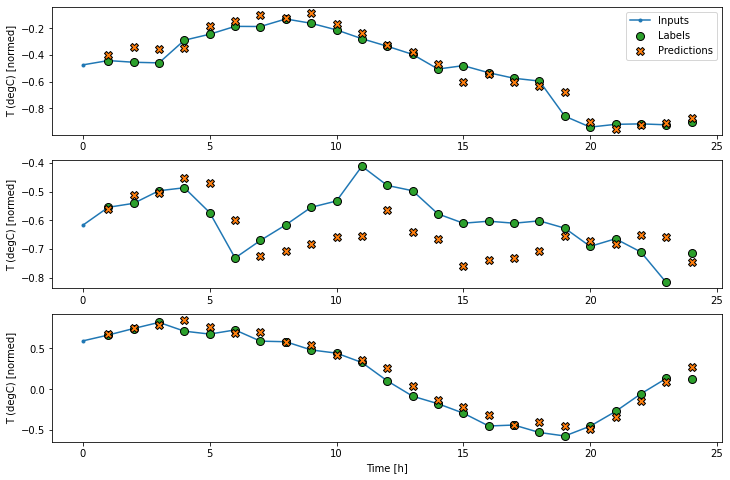

In [ ]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

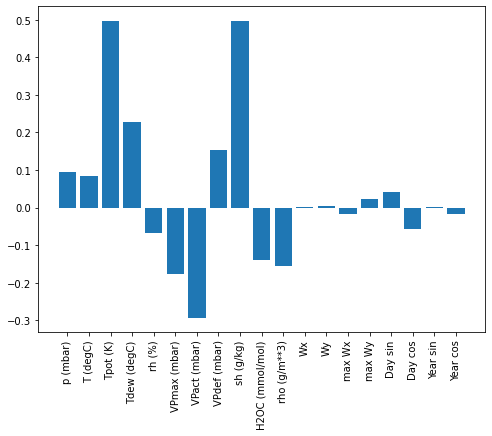

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 0s - loss: 1.1223 - mean_absolute_error: 0.8866

  17/1534 [..............................] - ETA: 4s - loss: 0.4262 - mean_absolute_error: 0.4831

  32/1534 [..............................] - ETA: 4s - loss: 0.2689 - mean_absolute_error: 0.3680

  48/1534 [..............................] - ETA: 4s - loss: 0.1939 - mean_absolute_error: 0.2990

  64/1534 [>.............................] - ETA: 4s - loss: 0.1508 - mean_absolute_error: 0.2533

  79/1534 [>.............................] - ETA: 4s - loss: 0.1265 - mean_absolute_error: 0.2269

  95/1534 [>.............................] - ETA: 4s - loss: 0.1088 - mean_absolute_error: 0.2069

 111/1534 [=>............................] - ETA: 4s - loss: 0.0951 - mean_absolute_error: 0.1901

 127/1534 [=>............................] - ETA: 4s - loss: 0.0849 - mean_absolute_error: 0.1778

 142/1534 [=>............................] - ETA: 4s - loss: 0.0776 - mean_absolute_error: 0.1689

 158/1534 [==>...........................] - ETA: 4s - loss: 0.0711 - mean_absolute_error: 0.1606

 174/1534 [==>...........................] - ETA: 4s - loss: 0.0659 - mean_absolute_error: 0.1541

 189/1534 [==>...........................] - ETA: 4s - loss: 0.0617 - mean_absolute_error: 0.1484

 204/1534 [==>...........................] - ETA: 4s - loss: 0.0581 - mean_absolute_error: 0.1438

 219/1534 [===>..........................] - ETA: 4s - loss: 0.0549 - mean_absolute_error: 0.1398

 235/1534 [===>..........................] - ETA: 4s - loss: 0.0520 - mean_absolute_error: 0.1358

 251/1534 [===>..........................] - ETA: 4s - loss: 0.0494 - mean_absolute_error: 0.1323

 267/1534 [====>.........................] - ETA: 4s - loss: 0.0471 - mean_absolute_error: 0.1294

 283/1534 [====>.........................] - ETA: 4s - loss: 0.0451 - mean_absolute_error: 0.1267

 300/1534 [====>.........................] - ETA: 4s - loss: 0.0433 - mean_absolute_error: 0.1243

 316/1534 [=====>........................] - ETA: 3s - loss: 0.0417 - mean_absolute_error: 0.1222

 331/1534 [=====>........................] - ETA: 3s - loss: 0.0403 - mean_absolute_error: 0.1204

 347/1534 [=====>........................] - ETA: 3s - loss: 0.0390 - mean_absolute_error: 0.1185

 363/1534 [======>.......................] - ETA: 3s - loss: 0.0378 - mean_absolute_error: 0.1168

 378/1534 [======>.......................] - ETA: 3s - loss: 0.0367 - mean_absolute_error: 0.1153

 393/1534 [======>.......................] - ETA: 3s - loss: 0.0357 - mean_absolute_error: 0.1137

 409/1534 [======>.......................] - ETA: 3s - loss: 0.0347 - mean_absolute_error: 0.1121

 425/1534 [=======>......................] - ETA: 3s - loss: 0.0337 - mean_absolute_error: 0.1108

 441/1534 [=======>......................] - ETA: 3s - loss: 0.0328 - mean_absolute_error: 0.1093

 457/1534 [=======>......................] - ETA: 3s - loss: 0.0320 - mean_absolute_error: 0.1080

 473/1534 [========>.....................] - ETA: 3s - loss: 0.0313 - mean_absolute_error: 0.1070

 489/1534 [========>.....................] - ETA: 3s - loss: 0.0306 - mean_absolute_error: 0.1059

 504/1534 [========>.....................] - ETA: 3s - loss: 0.0300 - mean_absolute_error: 0.1049

 520/1534 [=========>....................] - ETA: 3s - loss: 0.0295 - mean_absolute_error: 0.1042

 536/1534 [=========>....................] - ETA: 3s - loss: 0.0289 - mean_absolute_error: 0.1032

 551/1534 [=========>....................] - ETA: 3s - loss: 0.0284 - mean_absolute_error: 0.1024

 567/1534 [==========>...................] - ETA: 3s - loss: 0.0278 - mean_absolute_error: 0.1015

 583/1534 [==========>...................] - ETA: 3s - loss: 0.0273 - mean_absolute_error: 0.1007

 599/1534 [==========>...................] - ETA: 3s - loss: 0.0269 - mean_absolute_error: 0.0999

 615/1534 [===========>..................] - ETA: 2s - loss: 0.0265 - mean_absolute_error: 0.0993

 631/1534 [===========>..................] - ETA: 2s - loss: 0.0261 - mean_absolute_error: 0.0987

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0257 - mean_absolute_error: 0.0982

 662/1534 [===========>..................] - ETA: 2s - loss: 0.0253 - mean_absolute_error: 0.0975

 677/1534 [============>.................] - ETA: 2s - loss: 0.0249 - mean_absolute_error: 0.0970

 692/1534 [============>.................] - ETA: 2s - loss: 0.0245 - mean_absolute_error: 0.0963

 708/1534 [============>.................] - ETA: 2s - loss: 0.0242 - mean_absolute_error: 0.0958

 724/1534 [=============>................] - ETA: 2s - loss: 0.0239 - mean_absolute_error: 0.0952

 740/1534 [=============>................] - ETA: 2s - loss: 0.0235 - mean_absolute_error: 0.0947

 756/1534 [=============>................] - ETA: 2s - loss: 0.0233 - mean_absolute_error: 0.0942

 772/1534 [==============>...............] - ETA: 2s - loss: 0.0229 - mean_absolute_error: 0.0936

 787/1534 [==============>...............] - ETA: 2s - loss: 0.0226 - mean_absolute_error: 0.0932

 803/1534 [==============>...............] - ETA: 2s - loss: 0.0224 - mean_absolute_error: 0.0927

 818/1534 [==============>...............] - ETA: 2s - loss: 0.0221 - mean_absolute_error: 0.0922

 834/1534 [===============>..............] - ETA: 2s - loss: 0.0218 - mean_absolute_error: 0.0917

 850/1534 [===============>..............] - ETA: 2s - loss: 0.0216 - mean_absolute_error: 0.0913

 866/1534 [===============>..............] - ETA: 2s - loss: 0.0214 - mean_absolute_error: 0.0908

 882/1534 [================>.............] - ETA: 2s - loss: 0.0211 - mean_absolute_error: 0.0905

 898/1534 [================>.............] - ETA: 2s - loss: 0.0209 - mean_absolute_error: 0.0900

 914/1534 [================>.............] - ETA: 2s - loss: 0.0207 - mean_absolute_error: 0.0897

 929/1534 [=================>............] - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.0893

 945/1534 [=================>............] - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.0890

 960/1534 [=================>............] - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.0887

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0199 - mean_absolute_error: 0.0884

 991/1534 [==================>...........] - ETA: 1s - loss: 0.0197 - mean_absolute_error: 0.0880

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0196 - mean_absolute_error: 0.0878

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0194 - mean_absolute_error: 0.0876

1039/1534 [===================>..........] - ETA: 1s - loss: 0.0193 - mean_absolute_error: 0.0873

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0191 - mean_absolute_error: 0.0871

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0190 - mean_absolute_error: 0.0869

1088/1534 [====================>.........] - ETA: 1s - loss: 0.0188 - mean_absolute_error: 0.0867

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0187 - mean_absolute_error: 0.0865

1119/1534 [====================>.........] - ETA: 1s - loss: 0.0186 - mean_absolute_error: 0.0862

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0184 - mean_absolute_error: 0.0860

1151/1534 [=====================>........] - ETA: 1s - loss: 0.0183 - mean_absolute_error: 0.0856

1167/1534 [=====================>........] - ETA: 1s - loss: 0.0182 - mean_absolute_error: 0.0855

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0180 - mean_absolute_error: 0.0853

1198/1534 [======================>.......] - ETA: 1s - loss: 0.0179 - mean_absolute_error: 0.0850

1213/1534 [======================>.......] - ETA: 1s - loss: 0.0178 - mean_absolute_error: 0.0848

1229/1534 [=======================>......] - ETA: 0s - loss: 0.0177 - mean_absolute_error: 0.0846

1245/1534 [=======================>......] - ETA: 0s - loss: 0.0176 - mean_absolute_error: 0.0844

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0175 - mean_absolute_error: 0.0843

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0174 - mean_absolute_error: 0.0841

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0172 - mean_absolute_error: 0.0839

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0171 - mean_absolute_error: 0.0837

1322/1534 [========================>.....] - ETA: 0s - loss: 0.0171 - mean_absolute_error: 0.0836

1338/1534 [=========================>....] - ETA: 0s - loss: 0.0170 - mean_absolute_error: 0.0834

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0169 - mean_absolute_error: 0.0832

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0168 - mean_absolute_error: 0.0830

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0167 - mean_absolute_error: 0.0828

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0166 - mean_absolute_error: 0.0826

1418/1534 [==========================>...] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.0824

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0164 - mean_absolute_error: 0.0823

1450/1534 [===========================>..] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0822

1466/1534 [===========================>..] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0821

1481/1534 [===========================>..] - ETA: 0s - loss: 0.0162 - mean_absolute_error: 0.0819

1496/1534 [============================>.] - ETA: 0s - loss: 0.0161 - mean_absolute_error: 0.0817

1512/1534 [============================>.] - ETA: 0s - loss: 0.0160 - mean_absolute_error: 0.0816

1528/1534 [============================>.] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.0814

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0159 - mean_absolute_error: 0.0814 - val_loss: 0.0086 - val_mean_absolute_error: 0.0693


Epoch 2/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0581

  16/1534 [..............................] - ETA: 4s - loss: 0.0106 - mean_absolute_error: 0.0713

  32/1534 [..............................] - ETA: 4s - loss: 0.0092 - mean_absolute_error: 0.0683

  45/1534 [..............................] - ETA: 5s - loss: 0.0088 - mean_absolute_error: 0.0675

  60/1534 [>.............................] - ETA: 5s - loss: 0.0085 - mean_absolute_error: 0.0660

  75/1534 [>.............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0654

  90/1534 [>.............................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0659

 105/1534 [=>............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0653

 120/1534 [=>............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0650

 135/1534 [=>............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0651

 150/1534 [=>............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0648

 166/1534 [==>...........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0650

 180/1534 [==>...........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0651

 195/1534 [==>...........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0649

 211/1534 [===>..........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0652

 226/1534 [===>..........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0650

 242/1534 [===>..........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0652

 258/1534 [====>.........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0657

 274/1534 [====>.........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0659

 289/1534 [====>.........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0662

 305/1534 [====>.........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0660

 321/1534 [=====>........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0659

 337/1534 [=====>........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0659

 352/1534 [=====>........................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0661

 368/1534 [======>.......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0661

 384/1534 [======>.......................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0661

 400/1534 [======>.......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0658

 415/1534 [=======>......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0658

 431/1534 [=======>......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0658

 446/1534 [=======>......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0656

 462/1534 [========>.....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0657

 477/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0657

 493/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0658

 508/1534 [========>.....................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0659

 524/1534 [=========>....................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0659

 540/1534 [=========>....................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0659

 556/1534 [=========>....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0657

 571/1534 [==========>...................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0656

 586/1534 [==========>...................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0656

 601/1534 [==========>...................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0656

 616/1534 [===========>..................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0658

 631/1534 [===========>..................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0657

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0657

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0656

 677/1534 [============>.................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0656

 692/1534 [============>.................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0655

 707/1534 [============>.................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0655

 723/1534 [=============>................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0654

 738/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 754/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 771/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0653

 787/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 803/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 819/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 835/1534 [===============>..............] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0650

 851/1534 [===============>..............] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0650

 867/1534 [===============>..............] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0650

 882/1534 [================>.............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 897/1534 [================>.............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0650

 913/1534 [================>.............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0650

 929/1534 [=================>............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0650

 945/1534 [=================>............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0650

 961/1534 [=================>............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0650

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0650

 993/1534 [==================>...........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0648

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1118/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1134/1534 [=====================>........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0649

1149/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1165/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1181/1534 [======================>.......] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1198/1534 [======================>.......] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1214/1534 [======================>.......] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1231/1534 [=======================>......] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0649

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1295/1534 [========================>.....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1326/1534 [========================>.....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1342/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0649

1373/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1388/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1449/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1479/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1494/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1510/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1527/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0645

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0079 - mean_absolute_error: 0.0645 - val_loss: 0.0076 - val_mean_absolute_error: 0.0629


Epoch 3/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0166 - mean_absolute_error: 0.0812

  17/1534 [..............................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0686

  32/1534 [..............................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0667

  46/1534 [..............................] - ETA: 5s - loss: 0.0083 - mean_absolute_error: 0.0649

  62/1534 [>.............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0645

  78/1534 [>.............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0638

  94/1534 [>.............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0639

 110/1534 [=>............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0629

 126/1534 [=>............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0625

 142/1534 [=>............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0625

 158/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0624

 174/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0624

 189/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0624

 205/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0622

 221/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0622

 236/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0621

 251/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0622

 265/1534 [====>.........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0623

 282/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0622

 298/1534 [====>.........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0624

 313/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0623

 328/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0624

 344/1534 [=====>........................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0622

 359/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0623

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0622

 389/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0621

 405/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0621

 421/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0620

 437/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0621

 453/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0621

 469/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0620

 485/1534 [========>.....................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0622

 501/1534 [========>.....................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0623

 517/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0625

 533/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0625

 549/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0625

 565/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0624

 581/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0624

 597/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0624

 613/1534 [==========>...................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0626

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 645/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 677/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0627

 693/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0627

 709/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0626

 725/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0626

 740/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0626

 756/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0625

 772/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0625

 788/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0625

 805/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0625

 821/1534 [===============>..............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0624

 836/1534 [===============>..............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0623

 852/1534 [===============>..............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0624

 868/1534 [===============>..............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0624

 884/1534 [================>.............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0624

 900/1534 [================>.............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0624

 916/1534 [================>.............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0624

 931/1534 [=================>............] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0624

 946/1534 [=================>............] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0625

 962/1534 [=================>............] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0625

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0626

 993/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0625

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0625

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0626

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0626

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0626

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0626

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0628

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0628

1119/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1134/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1150/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1166/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1182/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1197/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1213/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1228/1534 [=======================>......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0627

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0626

1259/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0626

1274/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0626

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1336/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1413/1534 [==========================>...] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0623

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0623

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0623

1460/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0623

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0623

1492/1534 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0622

1508/1534 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0622

1524/1534 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0622

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0074 - mean_absolute_error: 0.0622 - val_loss: 0.0085 - val_mean_absolute_error: 0.0666


Epoch 4/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0443 - mean_absolute_error: 0.1110

  17/1534 [..............................] - ETA: 4s - loss: 0.0104 - mean_absolute_error: 0.0699

  33/1534 [..............................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0683

  48/1534 [..............................] - ETA: 5s - loss: 0.0086 - mean_absolute_error: 0.0658

  63/1534 [>.............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0647

  78/1534 [>.............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0643

  93/1534 [>.............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0643

 108/1534 [=>............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0630

 123/1534 [=>............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0622

 138/1534 [=>............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0621

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0620

 170/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0617

 186/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0613

 201/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0609

 216/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0608

 232/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0607

 247/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0610

 262/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0611

 277/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0610

 292/1534 [====>.........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0608

 307/1534 [=====>........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0606

 322/1534 [=====>........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0606

 337/1534 [=====>........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0605

 352/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0605

 367/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 382/1534 [======>.......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0607

 398/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 413/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0606

 428/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0605

 443/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0605

 459/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0605

 475/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 491/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 507/1534 [========>.....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0609

 522/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0612

 537/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0612

 553/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0610

 569/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0610

 584/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0611

 600/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0611

 616/1534 [===========>..................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0613

 631/1534 [===========>..................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0614

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0613

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 676/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0610

 691/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0610

 706/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0609

 721/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0607

 736/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0607

 752/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0607

 767/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0607

 783/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0607

 799/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0606

 815/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0606

 831/1534 [===============>..............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0605

 847/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 862/1534 [===============>..............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0605

 877/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0605

 892/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0605

 907/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0605

 923/1534 [=================>............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0606

 938/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0606

 953/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0606

 969/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0606

1001/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0605

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0606

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0606

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0606

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1080/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0610

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0610

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0611

1125/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0611

1141/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1157/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0611

1173/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0611

1188/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1203/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1218/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1234/1534 [=======================>......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1264/1534 [=======================>......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1308/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0611

1417/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1432/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1448/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1478/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1493/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1509/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1525/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0608 - val_loss: 0.0071 - val_mean_absolute_error: 0.0593


Epoch 5/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0603

  16/1534 [..............................] - ETA: 4s - loss: 0.0103 - mean_absolute_error: 0.0671

  32/1534 [..............................] - ETA: 4s - loss: 0.0086 - mean_absolute_error: 0.0640

  47/1534 [..............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0601

  62/1534 [>.............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0603

  77/1534 [>.............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0597

  93/1534 [>.............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0603

 108/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0603

 124/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0597

 140/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0595

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0590

 169/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0594

 185/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0592

 201/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0591

 217/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0589

 233/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0589

 249/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0589

 264/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0593

 279/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0593

 294/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0593

 309/1534 [=====>........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0593

 325/1534 [=====>........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0594

 342/1534 [=====>........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 358/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 390/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 406/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0592

 422/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 439/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 456/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 472/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 488/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 505/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0592

 520/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0594

 536/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0593

 551/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0593

 566/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0593

 582/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0593

 598/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0592

 613/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0594

 628/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0595

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0595

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0595

 676/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0594

 692/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0594

 707/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0593

 722/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0593

 738/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0592

 755/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0592

 771/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0592

 787/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 803/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 819/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0591

 835/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0591

 851/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 867/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0592

 883/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0593

 899/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0593

 914/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0592

 930/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0593

 945/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0593

 961/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0594

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

 993/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0594

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0594

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0594

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1055/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0594

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0595

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1119/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

1151/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

1166/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

1182/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1198/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1213/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1228/1534 [=======================>......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1258/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1350/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1396/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1411/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1489/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1505/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1521/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0595 - val_loss: 0.0067 - val_mean_absolute_error: 0.0579


Epoch 6/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0486

  16/1534 [..............................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0614

  32/1534 [..............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0609

  48/1534 [..............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0596

  64/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0591

  80/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0594

  96/1534 [>.............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0598

 111/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0595

 127/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0591

 142/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0589

 158/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0583

 174/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0585

 189/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0582

 204/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0584

 220/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0587

 235/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0590

 251/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0593

 266/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0596

 281/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0596

 296/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0596

 311/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0594

 327/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 343/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 360/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0596

 376/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0595

 392/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 408/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 424/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 439/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0595

 455/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0595

 471/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 487/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 503/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 519/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 535/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 551/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 566/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 582/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 597/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 613/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0593

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0594

 645/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0594

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 677/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 693/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 709/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0591

 725/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0590

 741/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0590

 757/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 773/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 788/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 804/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 820/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 833/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 849/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 865/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 880/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 895/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 911/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0588

 927/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

 943/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

 959/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

 991/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0587

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0587

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0587

1039/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0587

1055/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

1070/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1118/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

1133/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1148/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

1163/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1178/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1194/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1210/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1225/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1241/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1334/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1350/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1397/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1428/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1460/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1491/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1507/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1522/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0588 - val_loss: 0.0072 - val_mean_absolute_error: 0.0594


Epoch 7/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0577

  17/1534 [..............................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0616

  33/1534 [..............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0587

  48/1534 [..............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0579

  63/1534 [>.............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0580

  79/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0582

  95/1534 [>.............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0583

 111/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0584

 127/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0579

 143/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0574

 159/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0575

 175/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0575

 191/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0575

 206/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0575

 222/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0578

 238/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0579

 254/1534 [===>..........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0581

 270/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0583

 287/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0583

 303/1534 [====>.........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0583

 319/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0583

 335/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 350/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 365/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 381/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 396/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0583

 412/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0581

 427/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0581

 443/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0581

 459/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0581

 475/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0583

 491/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0583

 507/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0583

 523/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 538/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 554/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0584

 569/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 585/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0586

 602/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 618/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0586

 634/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0586

 649/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0585

 664/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0584

 680/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0584

 695/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0584

 711/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 728/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 744/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0582

 759/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0582

 774/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0582

 789/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0582

 805/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0582

 820/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0582

 835/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 851/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 867/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0582

 883/1534 [================>.............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0582

 899/1534 [================>.............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0582

 915/1534 [================>.............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0582

 930/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

 946/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

 962/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

 994/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1010/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1026/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1042/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1074/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1123/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1154/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1169/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1184/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1200/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1216/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1262/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1309/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0583

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1373/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1389/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1449/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1462/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1492/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1508/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1524/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0583 - val_loss: 0.0066 - val_mean_absolute_error: 0.0564


Epoch 8/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0562

  17/1534 [..............................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0616

  32/1534 [..............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0593

  48/1534 [..............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0586

  64/1534 [>.............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0580

  80/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0574

  95/1534 [>.............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0579

 111/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0574

 127/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0571

 143/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0567

 159/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0568

 175/1534 [==>...........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0567

 191/1534 [==>...........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0566

 207/1534 [===>..........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0567

 222/1534 [===>..........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0564

 238/1534 [===>..........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0568

 254/1534 [===>..........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0569

 269/1534 [====>.........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0573

 285/1534 [====>.........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0573

 301/1534 [====>.........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0574

 317/1534 [=====>........................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0573

 333/1534 [=====>........................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0574

 348/1534 [=====>........................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0576

 364/1534 [======>.......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0576

 379/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0578

 395/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 411/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0574

 427/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0575

 443/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0575

 458/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0574

 474/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0575

 490/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0575

 506/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 523/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0578

 539/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 555/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0578

 570/1534 [==========>...................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 585/1534 [==========>...................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 601/1534 [==========>...................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 616/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0578

 631/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0578

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0577

 662/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0576

 678/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0576

 694/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0576

 710/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 723/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0574

 738/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 753/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 784/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 799/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 815/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0572

 831/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0572

 847/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0572

 863/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0572

 879/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0572

 895/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0572

 911/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0572

 928/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

 944/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

 960/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0571

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0571

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1041/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0573

1057/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0573

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0574

1089/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0575

1104/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0575

1119/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0575

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0575

1151/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0575

1167/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0576

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

1198/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

1213/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

1228/1534 [=======================>......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1309/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1340/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1355/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1371/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1432/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1447/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0576

1479/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1495/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1511/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1526/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0066 - mean_absolute_error: 0.0576 - val_loss: 0.0078 - val_mean_absolute_error: 0.0637


Epoch 9/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0191 - mean_absolute_error: 0.0791

  16/1534 [..............................] - ETA: 4s - loss: 0.0130 - mean_absolute_error: 0.0818

  31/1534 [..............................] - ETA: 4s - loss: 0.0099 - mean_absolute_error: 0.0714

  46/1534 [..............................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0671

  61/1534 [>.............................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0659

  76/1534 [>.............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0636

  91/1534 [>.............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0619

 107/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0614

 123/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0607

 139/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0601

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0594

 170/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0592

 186/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0586

 202/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0585

 218/1534 [===>..........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0581

 234/1534 [===>..........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0582

 249/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0582

 264/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0583

 279/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0584

 295/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0583

 311/1534 [=====>........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0583

 326/1534 [=====>........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0582

 342/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0582

 357/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0583

 372/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0582

 387/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0581

 403/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0581

 418/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0580

 434/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 450/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 465/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0579

 480/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0580

 495/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 510/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 525/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 541/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0578

 557/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0578

 573/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0578

 589/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0578

 605/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0578

 620/1534 [===========>..................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0579

 634/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0580

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0578

 665/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0577

 681/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0578

 696/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0577

 711/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0577

 726/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0576

 742/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0576

 758/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0575

 774/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0575

 790/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0576

 806/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0575

 822/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 838/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0576

 854/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0576

 869/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0576

 885/1534 [================>.............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0576

 901/1534 [================>.............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0576

 916/1534 [================>.............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0576

 931/1534 [=================>............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0576

 946/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

 961/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

 991/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0576

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0576

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0576

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0576

1052/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0577

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0577

1083/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

1115/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

1130/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

1146/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

1162/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

1178/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

1194/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1210/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1226/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1242/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0577

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1336/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1413/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1491/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1504/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1520/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0066 - mean_absolute_error: 0.0576 - val_loss: 0.0066 - val_mean_absolute_error: 0.0564


Epoch 10/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0546

  16/1534 [..............................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0612

  31/1534 [..............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0586

  46/1534 [..............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0579

  62/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0570

  78/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0568

  94/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0566

 110/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0565

 125/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0557

 141/1534 [=>............................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0556

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0558

 171/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0563

 187/1534 [==>...........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0558

 202/1534 [==>...........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0557

 217/1534 [===>..........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0556

 233/1534 [===>..........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0559

 248/1534 [===>..........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0560

 264/1534 [====>.........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0563

 279/1534 [====>.........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0562

 294/1534 [====>.........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0564

 309/1534 [=====>........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0565

 325/1534 [=====>........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0564

 341/1534 [=====>........................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0565

 357/1534 [=====>........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0565

 373/1534 [======>.......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0566

 389/1534 [======>.......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0565

 404/1534 [======>.......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0565

 419/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0566

 434/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0567

 449/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0568

 463/1534 [========>.....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0568

 478/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0568

 494/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0568

 509/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0571

 525/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0572

 540/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0572

 556/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0571

 572/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0570

 588/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0572

 603/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0571

 618/1534 [===========>..................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0572

 633/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0572

 648/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 663/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0572

 679/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0572

 694/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0571

 710/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0570

 726/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0570

 741/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 756/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0569

 771/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0570

 786/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 801/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 817/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 833/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 849/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 865/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 881/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 897/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 913/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 930/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0570

 946/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0569

 962/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0569

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0569

 990/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0569

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0569

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0569

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0569

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0569

1070/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0570

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0571

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0571

1118/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0571

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0571

1151/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0571

1167/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0571

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0571

1199/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0571

1215/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0571

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1295/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1343/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1359/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1374/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

1439/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

1455/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

1471/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

1487/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

1503/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

1519/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0065 - mean_absolute_error: 0.0569 - val_loss: 0.0062 - val_mean_absolute_error: 0.0551


Epoch 11/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0603

  16/1534 [..............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0588

  32/1534 [..............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0563

  49/1534 [..............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0557

  64/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0562

  79/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0557

  95/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0564

 110/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0563

 125/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0558

 141/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0562

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0558

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0561

 187/1534 [==>...........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0560

 203/1534 [==>...........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0560

 218/1534 [===>..........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0561

 233/1534 [===>..........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0562

 248/1534 [===>..........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0564

 265/1534 [====>.........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0564

 281/1534 [====>.........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0565

 297/1534 [====>.........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0564

 313/1534 [=====>........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0562

 329/1534 [=====>........................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0562

 345/1534 [=====>........................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0564

 361/1534 [======>.......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0565

 376/1534 [======>.......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0566

 392/1534 [======>.......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0566

 408/1534 [======>.......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0565

 423/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0564

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0565

 454/1534 [=======>......................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0567

 469/1534 [========>.....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0567

 485/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0568

 501/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0569

 517/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0571

 533/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0572

 549/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0571

 564/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0571

 580/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0572

 595/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0573

 611/1534 [==========>...................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0574

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0574

 642/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0574

 657/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 672/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 687/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0572

 703/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0571

 719/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0570

 736/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0570

 752/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0570

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0570

 784/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 799/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 814/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 830/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 846/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0570

 862/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 878/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 894/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 910/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 925/1534 [=================>............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 941/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0570

 956/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0570

 971/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0570

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0569

1001/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0569

1017/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0569

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0570

1050/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0570

1066/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0570

1082/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1098/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0571

1112/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0571

1128/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0571

1144/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0571

1159/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0571

1175/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1190/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1206/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1222/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1238/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0572

1254/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1300/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1316/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1410/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0572

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0571

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1489/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1505/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1521/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0065 - mean_absolute_error: 0.0571 - val_loss: 0.0070 - val_mean_absolute_error: 0.0596


Epoch 12/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0709

  17/1534 [..............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0626

  32/1534 [..............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0615

  47/1534 [..............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0590

  63/1534 [>.............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0580

  79/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0569

  95/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0570

 111/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0565

 127/1534 [=>............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0562

 142/1534 [=>............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0561

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0559

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0559

 187/1534 [==>...........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0557

 202/1534 [==>...........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0557

 218/1534 [===>..........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0558

 235/1534 [===>..........................] - ETA: 4s - loss: 0.0062 - mean_absolute_error: 0.0556

 251/1534 [===>..........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0560

 267/1534 [====>.........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0563

 283/1534 [====>.........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0563

 298/1534 [====>.........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0563

 314/1534 [=====>........................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0562

 330/1534 [=====>........................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0561

 345/1534 [=====>........................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0561

 360/1534 [======>.......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0562

 376/1534 [======>.......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0562

 392/1534 [======>.......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0561

 408/1534 [======>.......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0561

 423/1534 [=======>......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0561

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0562

 454/1534 [=======>......................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0561

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0561

 485/1534 [========>.....................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0561

 500/1534 [========>.....................] - ETA: 3s - loss: 0.0063 - mean_absolute_error: 0.0562

 516/1534 [=========>....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0564

 531/1534 [=========>....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0564

 547/1534 [=========>....................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0564

 563/1534 [==========>...................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0563

 579/1534 [==========>...................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0564

 595/1534 [==========>...................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0564

 610/1534 [==========>...................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0565

 626/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0565

 642/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0566

 658/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0565

 675/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0564

 690/1534 [============>.................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0564

 705/1534 [============>.................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0564

 720/1534 [=============>................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0564

 736/1534 [=============>................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0565

 752/1534 [=============>................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0564

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0564

 784/1534 [==============>...............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0564

 800/1534 [==============>...............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0565

 816/1534 [==============>...............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0564

 832/1534 [===============>..............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0564

 848/1534 [===============>..............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0563

 864/1534 [===============>..............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0564

 879/1534 [================>.............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0564

 894/1534 [================>.............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0564

 909/1534 [================>.............] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0564

 925/1534 [=================>............] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0564

 941/1534 [=================>............] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0565

 957/1534 [=================>............] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0565

 973/1534 [==================>...........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0566

 989/1534 [==================>...........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0564

1004/1534 [==================>...........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0564

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0564

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0565

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0565

1065/1534 [===================>..........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0565

1081/1534 [====================>.........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0567

1097/1534 [====================>.........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0567

1114/1534 [====================>.........] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0566

1130/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0567

1146/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0567

1162/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0566

1178/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0567

1194/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0567

1210/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0567

1226/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0567

1242/1534 [=======================>......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0567

1258/1534 [=======================>......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0567

1274/1534 [=======================>......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0566

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0566

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1321/1534 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0566

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0566

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1447/1534 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1462/1534 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1492/1534 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1507/1534 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1522/1534 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0064 - mean_absolute_error: 0.0565 - val_loss: 0.0063 - val_mean_absolute_error: 0.0551


  1/439 [..............................] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0467

 19/439 [>.............................] - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.0545

 37/439 [=>............................] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0539

 54/439 [==>...........................] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0541

 72/439 [===>..........................] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0551

 89/439 [=====>........................] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0559

106/439 [======>.......................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0553

124/439 [=======>......................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0555

142/439 [========>.....................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0553

160/439 [=========>....................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0554

178/439 [===========>..................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0555

196/439 [============>.................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0553

214/439 [=============>................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0554

231/439 [==============>...............] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0552

248/439 [===============>..............] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0551

266/439 [=================>............] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0548

284/439 [==================>...........] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0550

302/439 [===================>..........] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0551

320/439 [====================>.........] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0550

338/439 [======================>.......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0553

356/439 [=======================>......] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0551

374/439 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0551

392/439 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0552

410/439 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0552

429/439 [============================>.] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0552

439/439 [==============================] - 1s 3ms/step - loss: 0.0063 - mean_absolute_error: 0.0551


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of the 3h of inputs and, 1h of labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

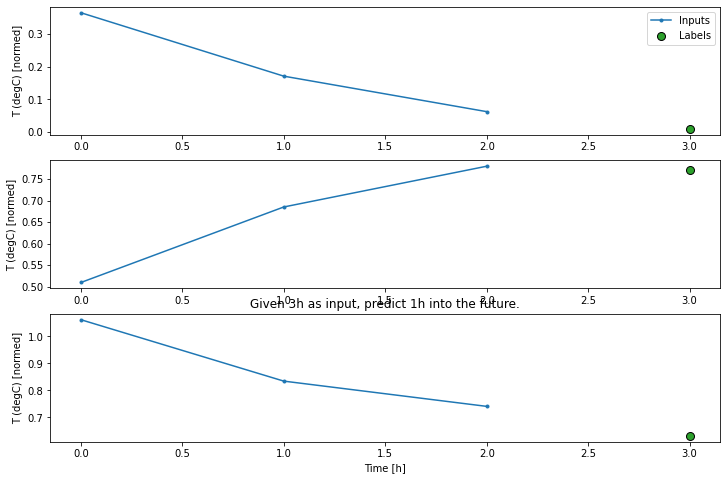

In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0596

 25/438 [>.............................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0625

 49/438 [==>...........................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0637

 73/438 [====>.........................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0636

 97/438 [=====>........................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0633

120/438 [=======>......................] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0634

143/438 [========>.....................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0628

166/438 [==========>...................] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0630

189/438 [===========>..................] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0632

211/438 [=============>................] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

234/438 [===============>..............] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0634

258/438 [================>.............] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0636

281/438 [==================>...........] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0635

305/438 [===================>..........] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0635

328/438 [=====================>........] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0635

352/438 [=======================>......] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0634

375/438 [========================>.....] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0633

398/438 [==========================>...] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0633

420/438 [===========================>..] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0636

438/438 [==============================] - 1s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0637


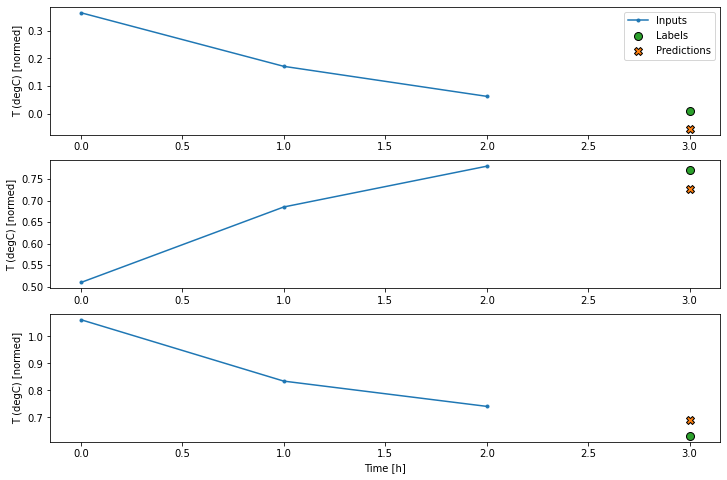

In [ ]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,456], In[1]: [57,32] [Op:MatMul]


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0650

 20/438 [>.............................] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0574

 39/438 [=>............................] - ETA: 1s - loss: 0.0063 - mean_absolute_error: 0.0554

 58/438 [==>...........................] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0553

 76/438 [====>.........................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0552

 95/438 [=====>........................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0549

113/438 [======>.......................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0556

132/438 [========>.....................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0554

150/438 [=========>....................] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0549

169/438 [==========>...................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0552

185/438 [===========>..................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0557

203/438 [============>.................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0554

222/438 [==============>...............] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0552

241/438 [===============>..............] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0553

259/438 [================>.............] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0553

278/438 [==================>...........] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0553

297/438 [===================>..........] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0552

316/438 [====================>.........] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0553

334/438 [=====================>........] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0553

352/438 [=======================>......] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0552

370/438 [========================>.....] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0553

389/438 [=========================>....] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0553

407/438 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0554

425/438 [============================>.] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0554

438/438 [==============================] - 1s 3ms/step - loss: 0.0063 - mean_absolute_error: 0.0556


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:

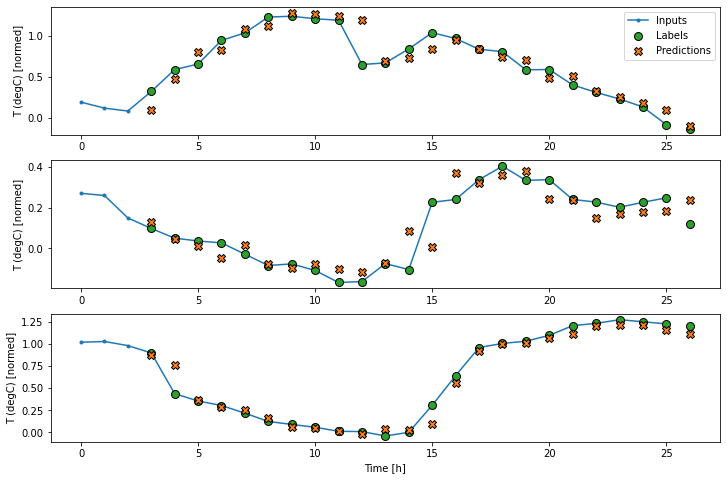

In [ ]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

For more details, read the [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) or the [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

In this tutorial, you will use an RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](images/lstm_1_window.png)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](images/lstm_many_window.png)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True` the model can be trained on 24h of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple `linear` and `dense` models shown earlier.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0487

 17/438 [>.............................] - ETA: 1s - loss: 0.0058 - mean_absolute_error: 0.0530

 34/438 [=>............................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0528

 50/438 [==>...........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0521

 66/438 [===>..........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0522

 82/438 [====>.........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0525

 98/438 [=====>........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0524

114/438 [======>.......................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0522

130/438 [=======>......................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0522

147/438 [=========>....................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0521

162/438 [==========>...................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0521

178/438 [===========>..................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0522

194/438 [============>.................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0522

210/438 [=============>................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0521

226/438 [==============>...............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0522

242/438 [===============>..............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0522

258/438 [================>.............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0523

274/438 [=================>............] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0523

289/438 [==================>...........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0523

305/438 [===================>..........] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0524

321/438 [====================>.........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0523

338/438 [======================>.......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0523

355/438 [=======================>......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0522

371/438 [========================>.....] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0522

386/438 [=========================>....] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0522

402/438 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0522

418/438 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0522

432/438 [============================>.] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0523

438/438 [==============================] - 1s 3ms/step - loss: 0.0057 - mean_absolute_error: 0.0523


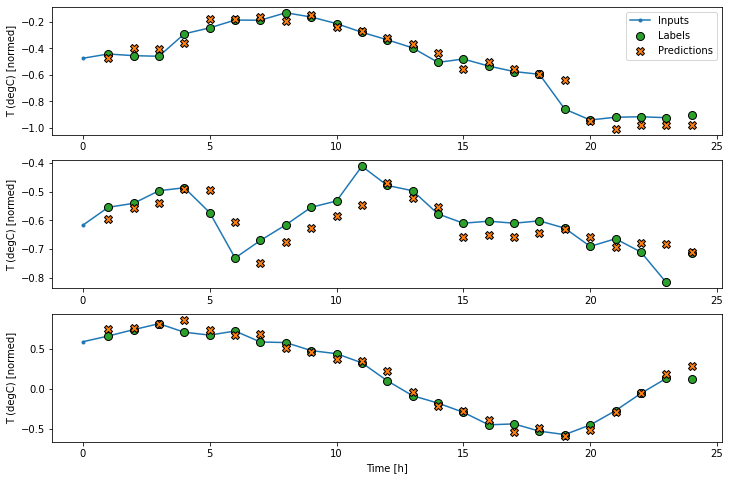

In [ ]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it.

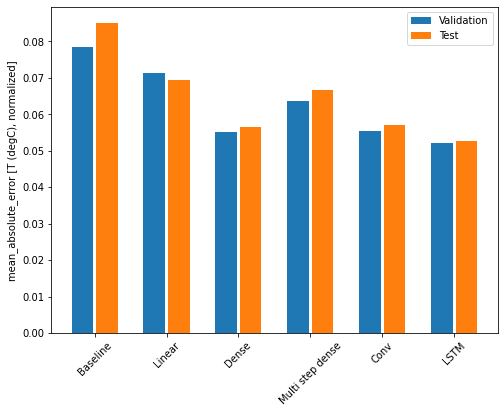

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0694
Dense       : 0.0566
Multi step dense: 0.0667
Conv        : 0.0572
LSTM        : 0.0528


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.


In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

#### Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 0s - loss: 0.0924 - mean_absolute_error: 0.1633

 24/438 [>.............................] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1594

 47/438 [==>...........................] - ETA: 0s - loss: 0.0863 - mean_absolute_error: 0.1574

 70/438 [===>..........................] - ETA: 0s - loss: 0.0866 - mean_absolute_error: 0.1575

 94/438 [=====>........................] - ETA: 0s - loss: 0.0866 - mean_absolute_error: 0.1576

117/438 [=======>......................] - ETA: 0s - loss: 0.0868 - mean_absolute_error: 0.1578

140/438 [========>.....................] - ETA: 0s - loss: 0.0873 - mean_absolute_error: 0.1581

163/438 [==========>...................] - ETA: 0s - loss: 0.0876 - mean_absolute_error: 0.1584

187/438 [===========>..................] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.1587

211/438 [=============>................] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1590

234/438 [===============>..............] - ETA: 0s - loss: 0.0883 - mean_absolute_error: 0.1590

259/438 [================>.............] - ETA: 0s - loss: 0.0884 - mean_absolute_error: 0.1590

284/438 [==================>...........] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1590

308/438 [====================>.........] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1590

331/438 [=====================>........] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1591

353/438 [=======================>......] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1591

377/438 [========================>.....] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1591

400/438 [==========================>...] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1590

423/438 [===========================>..] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

438/438 [==============================] - 1s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 0s - loss: 0.1078 - mean_absolute_error: 0.1635

 19/439 [>.............................] - ETA: 1s - loss: 0.0703 - mean_absolute_error: 0.1363

 37/439 [=>............................] - ETA: 1s - loss: 0.0696 - mean_absolute_error: 0.1355

 55/439 [==>...........................] - ETA: 1s - loss: 0.0683 - mean_absolute_error: 0.1346

 73/439 [===>..........................] - ETA: 1s - loss: 0.0694 - mean_absolute_error: 0.1348

 90/439 [=====>........................] - ETA: 0s - loss: 0.0707 - mean_absolute_error: 0.1355

108/439 [======>.......................] - ETA: 0s - loss: 0.0701 - mean_absolute_error: 0.1348

126/439 [=======>......................] - ETA: 0s - loss: 0.0704 - mean_absolute_error: 0.1350

144/439 [========>.....................] - ETA: 0s - loss: 0.0697 - mean_absolute_error: 0.1344

162/439 [==========>...................] - ETA: 0s - loss: 0.0700 - mean_absolute_error: 0.1347

179/439 [===========>..................] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.1343

197/439 [============>.................] - ETA: 0s - loss: 0.0691 - mean_absolute_error: 0.1344

214/439 [=============>................] - ETA: 0s - loss: 0.0690 - mean_absolute_error: 0.1343

232/439 [==============>...............] - ETA: 0s - loss: 0.0689 - mean_absolute_error: 0.1343

250/439 [================>.............] - ETA: 0s - loss: 0.0689 - mean_absolute_error: 0.1343

268/439 [=================>............] - ETA: 0s - loss: 0.0692 - mean_absolute_error: 0.1349

286/439 [==================>...........] - ETA: 0s - loss: 0.0696 - mean_absolute_error: 0.1352

305/439 [===================>..........] - ETA: 0s - loss: 0.0696 - mean_absolute_error: 0.1351

323/439 [=====================>........] - ETA: 0s - loss: 0.0700 - mean_absolute_error: 0.1353

341/439 [======================>.......] - ETA: 0s - loss: 0.0703 - mean_absolute_error: 0.1356

358/439 [=======================>......] - ETA: 0s - loss: 0.0704 - mean_absolute_error: 0.1357

376/439 [========================>.....] - ETA: 0s - loss: 0.0705 - mean_absolute_error: 0.1359

393/439 [=========================>....] - ETA: 0s - loss: 0.0707 - mean_absolute_error: 0.1361

411/439 [===========================>..] - ETA: 0s - loss: 0.0706 - mean_absolute_error: 0.1361

429/439 [============================>.] - ETA: 0s - loss: 0.0707 - mean_absolute_error: 0.1362

439/439 [==============================] - 1s 3ms/step - loss: 0.0706 - mean_absolute_error: 0.1362


#### RNN


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 0s - loss: 0.0541 - mean_absolute_error: 0.1146

 17/438 [>.............................] - ETA: 1s - loss: 0.0607 - mean_absolute_error: 0.1196

 34/438 [=>............................] - ETA: 1s - loss: 0.0618 - mean_absolute_error: 0.1201

 49/438 [==>...........................] - ETA: 1s - loss: 0.0618 - mean_absolute_error: 0.1200

 65/438 [===>..........................] - ETA: 1s - loss: 0.0618 - mean_absolute_error: 0.1199

 81/438 [====>.........................] - ETA: 1s - loss: 0.0613 - mean_absolute_error: 0.1194

 96/438 [=====>........................] - ETA: 1s - loss: 0.0618 - mean_absolute_error: 0.1196

112/438 [======>.......................] - ETA: 1s - loss: 0.0616 - mean_absolute_error: 0.1194

128/438 [=======>......................] - ETA: 1s - loss: 0.0619 - mean_absolute_error: 0.1197

144/438 [========>.....................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1198

160/438 [=========>....................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1197

176/438 [===========>..................] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1196

191/438 [============>.................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1196

207/438 [=============>................] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1196

223/438 [==============>...............] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1196

238/438 [===============>..............] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1195

253/438 [================>.............] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1195

269/438 [=================>............] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1194

285/438 [==================>...........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1194

301/438 [===================>..........] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1193

316/438 [====================>.........] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1193

331/438 [=====================>........] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1192

347/438 [======================>.......] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1191

363/438 [=======================>......] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1192

380/438 [=========================>....] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1193

396/438 [==========================>...] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1192

412/438 [===========================>..] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1192

427/438 [============================>.] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1192

438/438 [==============================] - 1s 3ms/step - loss: 0.0613 - mean_absolute_error: 0.1192



CPU times: user 6min 18s, sys: 1min 36s, total: 7min 55s
Wall time: 2min 53s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next timestep.
Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 0s - loss: 0.0639 - mean_absolute_error: 0.1201

 17/438 [>.............................] - ETA: 1s - loss: 0.0619 - mean_absolute_error: 0.1180

 33/438 [=>............................] - ETA: 1s - loss: 0.0614 - mean_absolute_error: 0.1176

 48/438 [==>...........................] - ETA: 1s - loss: 0.0618 - mean_absolute_error: 0.1180

 64/438 [===>..........................] - ETA: 1s - loss: 0.0619 - mean_absolute_error: 0.1182

 80/438 [====>.........................] - ETA: 1s - loss: 0.0613 - mean_absolute_error: 0.1178

 96/438 [=====>........................] - ETA: 1s - loss: 0.0612 - mean_absolute_error: 0.1175

112/438 [======>.......................] - ETA: 1s - loss: 0.0615 - mean_absolute_error: 0.1178

128/438 [=======>......................] - ETA: 1s - loss: 0.0613 - mean_absolute_error: 0.1175

144/438 [========>.....................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1179

160/438 [=========>....................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1181

176/438 [===========>..................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1181

192/438 [============>.................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1181

208/438 [=============>................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1181

224/438 [==============>...............] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1181

240/438 [===============>..............] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1182

256/438 [================>.............] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1181

272/438 [=================>............] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1180

286/438 [==================>...........] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1181

301/438 [===================>..........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1182

316/438 [====================>.........] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1183

332/438 [=====================>........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1182

347/438 [======================>.......] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1182

363/438 [=======================>......] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1182

379/438 [========================>.....] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1181

395/438 [==========================>...] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1181

411/438 [===========================>..] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1181

427/438 [============================>.] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1182

438/438 [==============================] - 1s 3ms/step - loss: 0.0619 - mean_absolute_error: 0.1181



CPU times: user 2min 2s, sys: 31.2 s, total: 2min 33s
Wall time: 56.9 s


#### Performance

Here is the overall performance for these multi-output models.

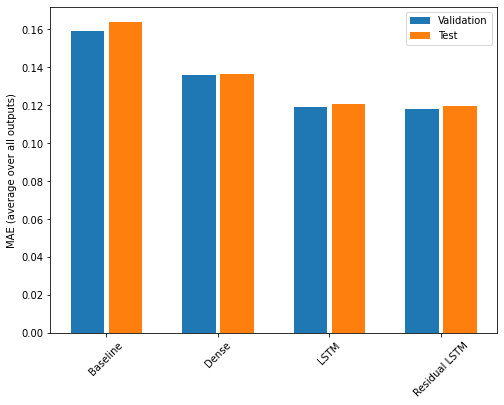

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1367
LSTM           : 0.1208
Residual LSTM  : 0.1197


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, 1h into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

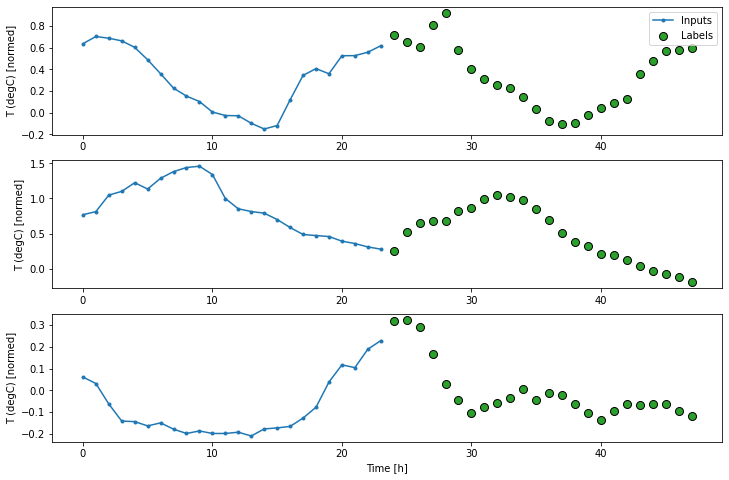

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Repeat the last input, for each output step](images/multistep_last.png)

  1/437 [..............................] - ETA: 0s - loss: 0.6227 - mean_absolute_error: 0.5160

 25/437 [>.............................] - ETA: 0s - loss: 0.6302 - mean_absolute_error: 0.5006

 49/437 [==>...........................] - ETA: 0s - loss: 0.6347 - mean_absolute_error: 0.5025

 72/437 [===>..........................] - ETA: 0s - loss: 0.6262 - mean_absolute_error: 0.4997

 96/437 [=====>........................] - ETA: 0s - loss: 0.6295 - mean_absolute_error: 0.5006

120/437 [=======>......................] - ETA: 0s - loss: 0.6291 - mean_absolute_error: 0.5007

143/437 [========>.....................] - ETA: 0s - loss: 0.6294 - mean_absolute_error: 0.5009

166/437 [==========>...................] - ETA: 0s - loss: 0.6316 - mean_absolute_error: 0.5017

188/437 [===========>..................] - ETA: 0s - loss: 0.6308 - mean_absolute_error: 0.5016

210/437 [=============>................] - ETA: 0s - loss: 0.6287 - mean_absolute_error: 0.5007

234/437 [===============>..............] - ETA: 0s - loss: 0.6290 - mean_absolute_error: 0.5009

256/437 [================>.............] - ETA: 0s - loss: 0.6269 - mean_absolute_error: 0.5000

279/437 [==================>...........] - ETA: 0s - loss: 0.6278 - mean_absolute_error: 0.5005

302/437 [===================>..........] - ETA: 0s - loss: 0.6309 - mean_absolute_error: 0.5016

325/437 [=====================>........] - ETA: 0s - loss: 0.6302 - mean_absolute_error: 0.5015

348/437 [======================>.......] - ETA: 0s - loss: 0.6296 - mean_absolute_error: 0.5013

371/437 [========================>.....] - ETA: 0s - loss: 0.6299 - mean_absolute_error: 0.5014

394/437 [==========================>...] - ETA: 0s - loss: 0.6302 - mean_absolute_error: 0.5016

418/437 [===========================>..] - ETA: 0s - loss: 0.6296 - mean_absolute_error: 0.5011

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


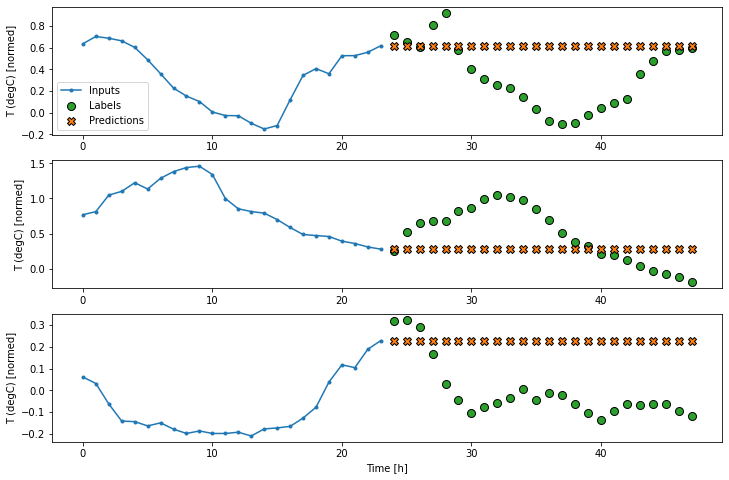

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24h given 24h another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 0s - loss: 0.3879 - mean_absolute_error: 0.3709

 23/437 [>.............................] - ETA: 0s - loss: 0.4262 - mean_absolute_error: 0.3938

 46/437 [==>...........................] - ETA: 0s - loss: 0.4403 - mean_absolute_error: 0.4024

 69/437 [===>..........................] - ETA: 0s - loss: 0.4358 - mean_absolute_error: 0.4007

 93/437 [=====>........................] - ETA: 0s - loss: 0.4287 - mean_absolute_error: 0.3970

116/437 [======>.......................] - ETA: 0s - loss: 0.4290 - mean_absolute_error: 0.3970

139/437 [========>.....................] - ETA: 0s - loss: 0.4276 - mean_absolute_error: 0.3967

163/437 [==========>...................] - ETA: 0s - loss: 0.4266 - mean_absolute_error: 0.3959

186/437 [===========>..................] - ETA: 0s - loss: 0.4266 - mean_absolute_error: 0.3963

210/437 [=============>................] - ETA: 0s - loss: 0.4273 - mean_absolute_error: 0.3966

233/437 [==============>...............] - ETA: 0s - loss: 0.4278 - mean_absolute_error: 0.3968

256/437 [================>.............] - ETA: 0s - loss: 0.4275 - mean_absolute_error: 0.3964

279/437 [==================>...........] - ETA: 0s - loss: 0.4261 - mean_absolute_error: 0.3956

303/437 [===================>..........] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.3958

328/437 [=====================>........] - ETA: 0s - loss: 0.4275 - mean_absolute_error: 0.3961

350/437 [=======================>......] - ETA: 0s - loss: 0.4280 - mean_absolute_error: 0.3962

372/437 [========================>.....] - ETA: 0s - loss: 0.4285 - mean_absolute_error: 0.3964

395/437 [==========================>...] - ETA: 0s - loss: 0.4280 - mean_absolute_error: 0.3962

419/437 [===========================>..] - ETA: 0s - loss: 0.4274 - mean_absolute_error: 0.3961

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


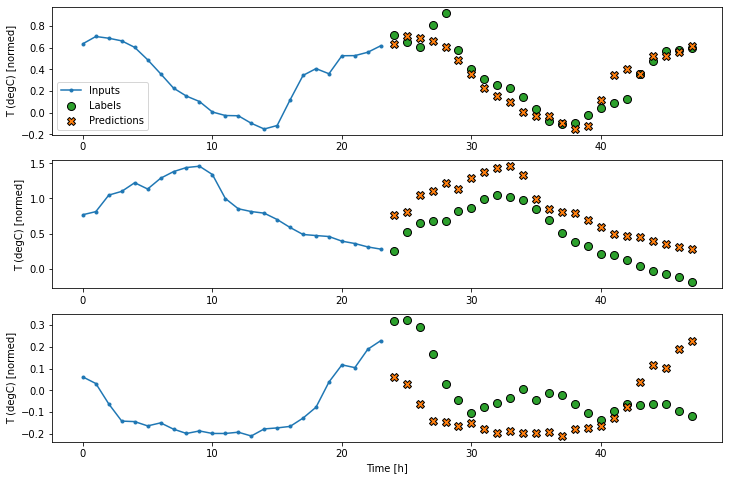

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predct all timesteps from the last time-step](images/multistep_dense.png)

  1/437 [..............................] - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.2934

 21/437 [>.............................] - ETA: 1s - loss: 0.2473 - mean_absolute_error: 0.3020

 42/437 [=>............................] - ETA: 0s - loss: 0.2504 - mean_absolute_error: 0.3037

 63/437 [===>..........................] - ETA: 0s - loss: 0.2532 - mean_absolute_error: 0.3044

 84/437 [====>.........................] - ETA: 0s - loss: 0.2561 - mean_absolute_error: 0.3061

105/437 [======>.......................] - ETA: 0s - loss: 0.2548 - mean_absolute_error: 0.3053

126/437 [=======>......................] - ETA: 0s - loss: 0.2541 - mean_absolute_error: 0.3046

146/437 [=========>....................] - ETA: 0s - loss: 0.2552 - mean_absolute_error: 0.3052

167/437 [==========>...................] - ETA: 0s - loss: 0.2551 - mean_absolute_error: 0.3052

187/437 [===========>..................] - ETA: 0s - loss: 0.2541 - mean_absolute_error: 0.3047

208/437 [=============>................] - ETA: 0s - loss: 0.2530 - mean_absolute_error: 0.3042

229/437 [==============>...............] - ETA: 0s - loss: 0.2538 - mean_absolute_error: 0.3047

249/437 [================>.............] - ETA: 0s - loss: 0.2544 - mean_absolute_error: 0.3047

269/437 [=================>............] - ETA: 0s - loss: 0.2552 - mean_absolute_error: 0.3052

289/437 [==================>...........] - ETA: 0s - loss: 0.2556 - mean_absolute_error: 0.3052

309/437 [====================>.........] - ETA: 0s - loss: 0.2553 - mean_absolute_error: 0.3050

329/437 [=====================>........] - ETA: 0s - loss: 0.2554 - mean_absolute_error: 0.3051

349/437 [======================>.......] - ETA: 0s - loss: 0.2552 - mean_absolute_error: 0.3050

370/437 [========================>.....] - ETA: 0s - loss: 0.2552 - mean_absolute_error: 0.3049

391/437 [=========================>....] - ETA: 0s - loss: 0.2552 - mean_absolute_error: 0.3047

411/437 [===========================>..] - ETA: 0s - loss: 0.2554 - mean_absolute_error: 0.3048

430/437 [============================>.] - ETA: 0s - loss: 0.2558 - mean_absolute_error: 0.3051

437/437 [==============================] - 1s 2ms/step - loss: 0.2556 - mean_absolute_error: 0.3050


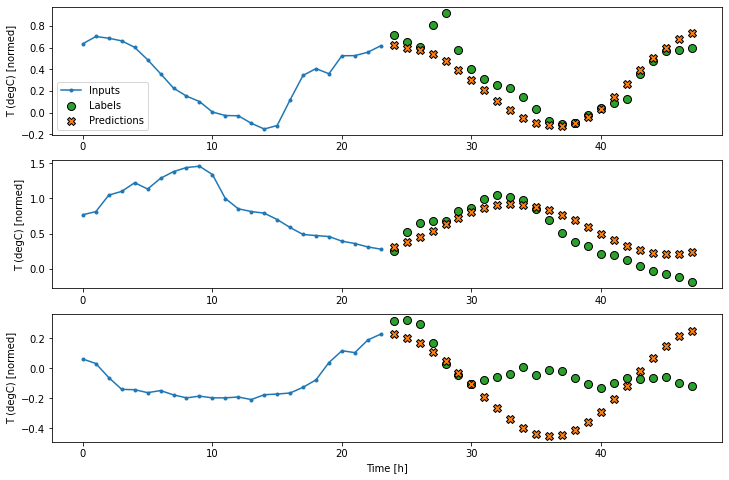

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input timestep.

  1/437 [..............................] - ETA: 0s - loss: 0.2710 - mean_absolute_error: 0.3216

 19/437 [>.............................] - ETA: 1s - loss: 0.2236 - mean_absolute_error: 0.2847

 37/437 [=>............................] - ETA: 1s - loss: 0.2186 - mean_absolute_error: 0.2820

 54/437 [==>...........................] - ETA: 1s - loss: 0.2167 - mean_absolute_error: 0.2805

 72/437 [===>..........................] - ETA: 1s - loss: 0.2199 - mean_absolute_error: 0.2817

 91/437 [=====>........................] - ETA: 0s - loss: 0.2191 - mean_absolute_error: 0.2811

110/437 [======>.......................] - ETA: 0s - loss: 0.2209 - mean_absolute_error: 0.2821

129/437 [=======>......................] - ETA: 0s - loss: 0.2210 - mean_absolute_error: 0.2820

148/437 [=========>....................] - ETA: 0s - loss: 0.2202 - mean_absolute_error: 0.2814

166/437 [==========>...................] - ETA: 0s - loss: 0.2196 - mean_absolute_error: 0.2810

184/437 [===========>..................] - ETA: 0s - loss: 0.2183 - mean_absolute_error: 0.2801

202/437 [============>.................] - ETA: 0s - loss: 0.2195 - mean_absolute_error: 0.2805

221/437 [==============>...............] - ETA: 0s - loss: 0.2199 - mean_absolute_error: 0.2809

240/437 [===============>..............] - ETA: 0s - loss: 0.2198 - mean_absolute_error: 0.2807

259/437 [================>.............] - ETA: 0s - loss: 0.2194 - mean_absolute_error: 0.2802

277/437 [==================>...........] - ETA: 0s - loss: 0.2198 - mean_absolute_error: 0.2805

295/437 [===================>..........] - ETA: 0s - loss: 0.2196 - mean_absolute_error: 0.2807

313/437 [====================>.........] - ETA: 0s - loss: 0.2202 - mean_absolute_error: 0.2809

331/437 [=====================>........] - ETA: 0s - loss: 0.2203 - mean_absolute_error: 0.2811

350/437 [=======================>......] - ETA: 0s - loss: 0.2202 - mean_absolute_error: 0.2812

369/437 [========================>.....] - ETA: 0s - loss: 0.2201 - mean_absolute_error: 0.2810

388/437 [=========================>....] - ETA: 0s - loss: 0.2200 - mean_absolute_error: 0.2811

407/437 [==========================>...] - ETA: 0s - loss: 0.2200 - mean_absolute_error: 0.2811

425/437 [============================>.] - ETA: 0s - loss: 0.2195 - mean_absolute_error: 0.2808

437/437 [==============================] - 1s 3ms/step - loss: 0.2192 - mean_absolute_error: 0.2807


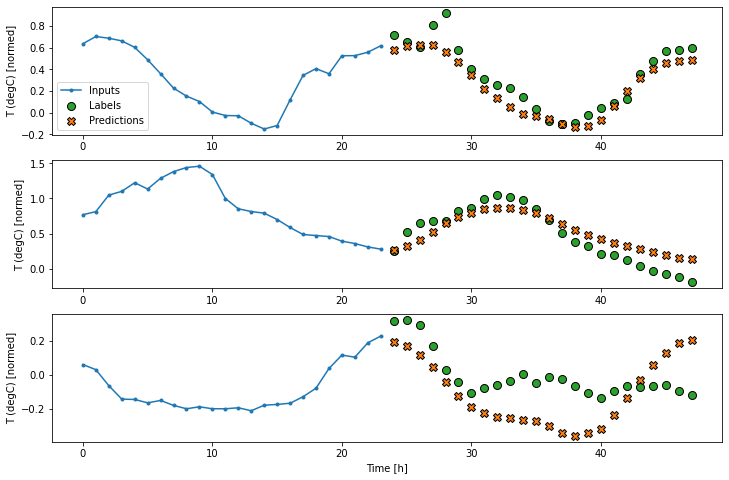

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

  1/437 [..............................] - ETA: 0s - loss: 0.2549 - mean_absolute_error: 0.3116

 20/437 [>.............................] - ETA: 1s - loss: 0.2153 - mean_absolute_error: 0.2819

 41/437 [=>............................] - ETA: 0s - loss: 0.2180 - mean_absolute_error: 0.2819

 62/437 [===>..........................] - ETA: 0s - loss: 0.2168 - mean_absolute_error: 0.2816

 82/437 [====>.........................] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.2812

102/437 [======>.......................] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2812

122/437 [=======>......................] - ETA: 0s - loss: 0.2170 - mean_absolute_error: 0.2819

143/437 [========>.....................] - ETA: 0s - loss: 0.2170 - mean_absolute_error: 0.2822

162/437 [==========>...................] - ETA: 0s - loss: 0.2170 - mean_absolute_error: 0.2820

182/437 [===========>..................] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2814

202/437 [============>.................] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2811

221/437 [==============>...............] - ETA: 0s - loss: 0.2150 - mean_absolute_error: 0.2809

240/437 [===============>..............] - ETA: 0s - loss: 0.2148 - mean_absolute_error: 0.2808

259/437 [================>.............] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2807

279/437 [==================>...........] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2810

298/437 [===================>..........] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2808

318/437 [====================>.........] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2808

338/437 [======================>.......] - ETA: 0s - loss: 0.2141 - mean_absolute_error: 0.2806

357/437 [=======================>......] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2806

376/437 [========================>.....] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2806

396/437 [==========================>...] - ETA: 0s - loss: 0.2141 - mean_absolute_error: 0.2805

416/437 [===========================>..] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2803

432/437 [============================>.] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2806

437/437 [==============================] - 1s 3ms/step - loss: 0.2142 - mean_absolute_error: 0.2805


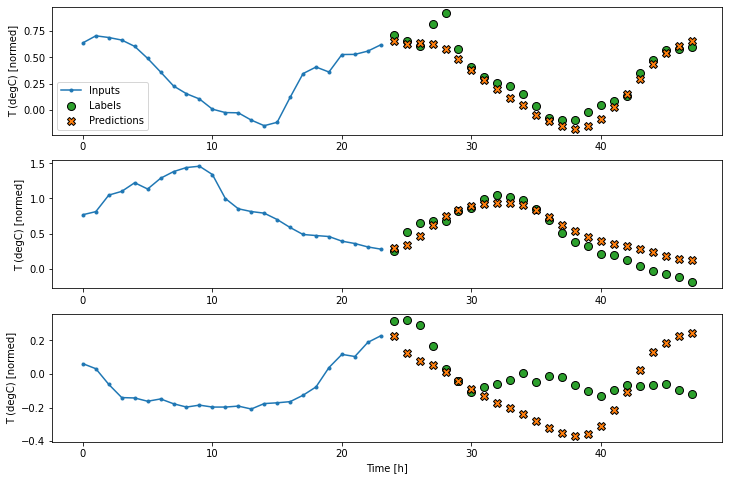

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 0s - loss: 0.1718 - mean_absolute_error: 0.2629

 18/437 [>.............................] - ETA: 1s - loss: 0.2244 - mean_absolute_error: 0.2881

 35/437 [=>............................] - ETA: 1s - loss: 0.2171 - mean_absolute_error: 0.2851

 52/437 [==>...........................] - ETA: 1s - loss: 0.2185 - mean_absolute_error: 0.2861

 69/437 [===>..........................] - ETA: 1s - loss: 0.2170 - mean_absolute_error: 0.2847

 86/437 [====>.........................] - ETA: 1s - loss: 0.2158 - mean_absolute_error: 0.2840

103/437 [======>.......................] - ETA: 1s - loss: 0.2154 - mean_absolute_error: 0.2839

120/437 [=======>......................] - ETA: 0s - loss: 0.2164 - mean_absolute_error: 0.2840

137/437 [========>.....................] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2845

154/437 [=========>....................] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.2848

171/437 [==========>...................] - ETA: 0s - loss: 0.2162 - mean_absolute_error: 0.2839

189/437 [===========>..................] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2837

206/437 [=============>................] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2838

224/437 [==============>...............] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2834

241/437 [===============>..............] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.2830

258/437 [================>.............] - ETA: 0s - loss: 0.2148 - mean_absolute_error: 0.2829

275/437 [=================>............] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2829

292/437 [===================>..........] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2827

309/437 [====================>.........] - ETA: 0s - loss: 0.2143 - mean_absolute_error: 0.2825

326/437 [=====================>........] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2825

343/437 [======================>.......] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2823

360/437 [=======================>......] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2823

377/437 [========================>.....] - ETA: 0s - loss: 0.2143 - mean_absolute_error: 0.2825

394/437 [==========================>...] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2825

411/437 [===========================>..] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2825

428/437 [============================>.] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2828

437/437 [==============================] - 1s 3ms/step - loss: 0.2146 - mean_absolute_error: 0.2829


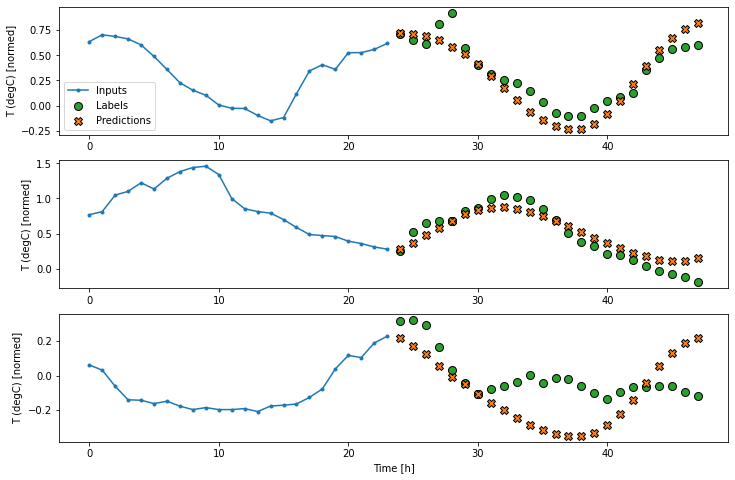

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence as a in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of single single-step multi-output models trained in the first half of this tutorial and run  in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)


#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single timestep.

The model will have the same basic form as the single-step `LSTM` models: An `LSTM` followed by a `layers.Dense` that converts the `LSTM` outputs to model predictions.

A `layers.LSTM` is a `layers.LSTMCell` wrapped in the higher level `layers.RNN` that manages the state and sequence results for you (See [Keras RNNs](https://www.tensorflow.org/guide/keras/rnn) for details).

In this case the model has to manually manage the inputs for each step so it uses `layers.LSTMCell` directly for the lower level, single time step interface.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction, and the internal state of the LSTM:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach to collecting the output predictions is to use a python list, and `tf.stack` after the loop.

Note: Stacking a python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length you would need to use a `tf.TensorArray` instead of a python list, and `tf.range` instead of the python `range`.

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now train the model:

  1/437 [..............................] - ETA: 0s - loss: 0.1866 - mean_absolute_error: 0.2810

  8/437 [..............................] - ETA: 2s - loss: 0.2322 - mean_absolute_error: 0.3126

 15/437 [>.............................] - ETA: 3s - loss: 0.2354 - mean_absolute_error: 0.3130

 21/437 [>.............................] - ETA: 3s - loss: 0.2317 - mean_absolute_error: 0.3116

 27/437 [>.............................] - ETA: 3s - loss: 0.2317 - mean_absolute_error: 0.3112

 34/437 [=>............................] - ETA: 3s - loss: 0.2339 - mean_absolute_error: 0.3113

 41/437 [=>............................] - ETA: 3s - loss: 0.2334 - mean_absolute_error: 0.3112

 48/437 [==>...........................] - ETA: 3s - loss: 0.2353 - mean_absolute_error: 0.3115

 55/437 [==>...........................] - ETA: 2s - loss: 0.2361 - mean_absolute_error: 0.3115

 62/437 [===>..........................] - ETA: 2s - loss: 0.2370 - mean_absolute_error: 0.3120

 69/437 [===>..........................] - ETA: 2s - loss: 0.2385 - mean_absolute_error: 0.3122

 76/437 [====>.........................] - ETA: 2s - loss: 0.2390 - mean_absolute_error: 0.3129

 83/437 [====>.........................] - ETA: 2s - loss: 0.2396 - mean_absolute_error: 0.3134

 90/437 [=====>........................] - ETA: 2s - loss: 0.2388 - mean_absolute_error: 0.3132

 96/437 [=====>........................] - ETA: 2s - loss: 0.2397 - mean_absolute_error: 0.3136

103/437 [======>.......................] - ETA: 2s - loss: 0.2389 - mean_absolute_error: 0.3132

110/437 [======>.......................] - ETA: 2s - loss: 0.2383 - mean_absolute_error: 0.3130

117/437 [=======>......................] - ETA: 2s - loss: 0.2378 - mean_absolute_error: 0.3126

124/437 [=======>......................] - ETA: 2s - loss: 0.2382 - mean_absolute_error: 0.3127

131/437 [=======>......................] - ETA: 2s - loss: 0.2382 - mean_absolute_error: 0.3129

137/437 [========>.....................] - ETA: 2s - loss: 0.2395 - mean_absolute_error: 0.3136

144/437 [========>.....................] - ETA: 2s - loss: 0.2392 - mean_absolute_error: 0.3134

151/437 [=========>....................] - ETA: 2s - loss: 0.2390 - mean_absolute_error: 0.3132

157/437 [=========>....................] - ETA: 2s - loss: 0.2396 - mean_absolute_error: 0.3135

164/437 [==========>...................] - ETA: 2s - loss: 0.2389 - mean_absolute_error: 0.3132

170/437 [==========>...................] - ETA: 2s - loss: 0.2387 - mean_absolute_error: 0.3132

177/437 [===========>..................] - ETA: 2s - loss: 0.2383 - mean_absolute_error: 0.3131

184/437 [===========>..................] - ETA: 1s - loss: 0.2381 - mean_absolute_error: 0.3128

191/437 [============>.................] - ETA: 1s - loss: 0.2374 - mean_absolute_error: 0.3124

198/437 [============>.................] - ETA: 1s - loss: 0.2375 - mean_absolute_error: 0.3124

205/437 [=============>................] - ETA: 1s - loss: 0.2378 - mean_absolute_error: 0.3126

212/437 [=============>................] - ETA: 1s - loss: 0.2374 - mean_absolute_error: 0.3124

219/437 [==============>...............] - ETA: 1s - loss: 0.2368 - mean_absolute_error: 0.3122

226/437 [==============>...............] - ETA: 1s - loss: 0.2368 - mean_absolute_error: 0.3123

233/437 [==============>...............] - ETA: 1s - loss: 0.2365 - mean_absolute_error: 0.3121

240/437 [===============>..............] - ETA: 1s - loss: 0.2367 - mean_absolute_error: 0.3124

247/437 [===============>..............] - ETA: 1s - loss: 0.2367 - mean_absolute_error: 0.3123

254/437 [================>.............] - ETA: 1s - loss: 0.2374 - mean_absolute_error: 0.3126

261/437 [================>.............] - ETA: 1s - loss: 0.2375 - mean_absolute_error: 0.3126

268/437 [=================>............] - ETA: 1s - loss: 0.2378 - mean_absolute_error: 0.3128

275/437 [=================>............] - ETA: 1s - loss: 0.2376 - mean_absolute_error: 0.3126

282/437 [==================>...........] - ETA: 1s - loss: 0.2374 - mean_absolute_error: 0.3125

289/437 [==================>...........] - ETA: 1s - loss: 0.2370 - mean_absolute_error: 0.3123

296/437 [===================>..........] - ETA: 1s - loss: 0.2369 - mean_absolute_error: 0.3123

303/437 [===================>..........] - ETA: 1s - loss: 0.2372 - mean_absolute_error: 0.3123

310/437 [====================>.........] - ETA: 0s - loss: 0.2371 - mean_absolute_error: 0.3123

316/437 [====================>.........] - ETA: 0s - loss: 0.2370 - mean_absolute_error: 0.3123

323/437 [=====================>........] - ETA: 0s - loss: 0.2367 - mean_absolute_error: 0.3121

329/437 [=====================>........] - ETA: 0s - loss: 0.2366 - mean_absolute_error: 0.3121

335/437 [=====================>........] - ETA: 0s - loss: 0.2367 - mean_absolute_error: 0.3122

342/437 [======================>.......] - ETA: 0s - loss: 0.2371 - mean_absolute_error: 0.3125

348/437 [======================>.......] - ETA: 0s - loss: 0.2371 - mean_absolute_error: 0.3124

355/437 [=======================>......] - ETA: 0s - loss: 0.2369 - mean_absolute_error: 0.3124

362/437 [=======================>......] - ETA: 0s - loss: 0.2366 - mean_absolute_error: 0.3122

369/437 [========================>.....] - ETA: 0s - loss: 0.2365 - mean_absolute_error: 0.3122

376/437 [========================>.....] - ETA: 0s - loss: 0.2365 - mean_absolute_error: 0.3123

382/437 [=========================>....] - ETA: 0s - loss: 0.2363 - mean_absolute_error: 0.3121

389/437 [=========================>....] - ETA: 0s - loss: 0.2362 - mean_absolute_error: 0.3121

396/437 [==========================>...] - ETA: 0s - loss: 0.2364 - mean_absolute_error: 0.3122

403/437 [==========================>...] - ETA: 0s - loss: 0.2361 - mean_absolute_error: 0.3121

410/437 [===========================>..] - ETA: 0s - loss: 0.2361 - mean_absolute_error: 0.3120

417/437 [===========================>..] - ETA: 0s - loss: 0.2358 - mean_absolute_error: 0.3118

424/437 [============================>.] - ETA: 0s - loss: 0.2356 - mean_absolute_error: 0.3118

430/437 [============================>.] - ETA: 0s - loss: 0.2355 - mean_absolute_error: 0.3118

437/437 [==============================] - ETA: 0s - loss: 0.2352 - mean_absolute_error: 0.3116

437/437 [==============================] - 3s 8ms/step - loss: 0.2352 - mean_absolute_error: 0.3116


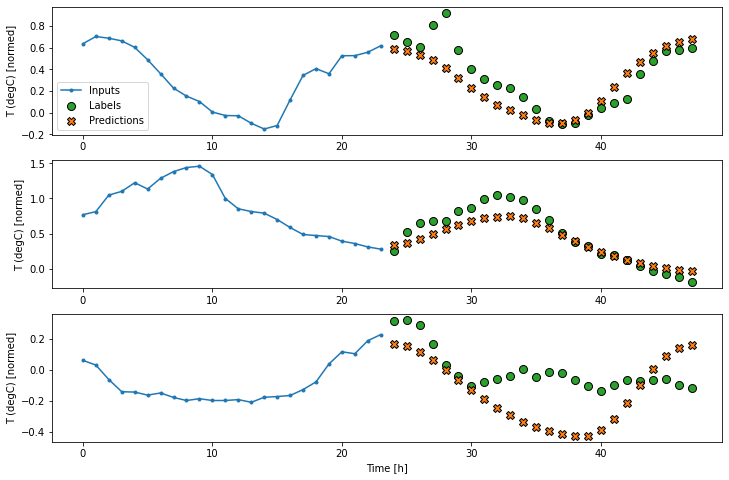

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem.

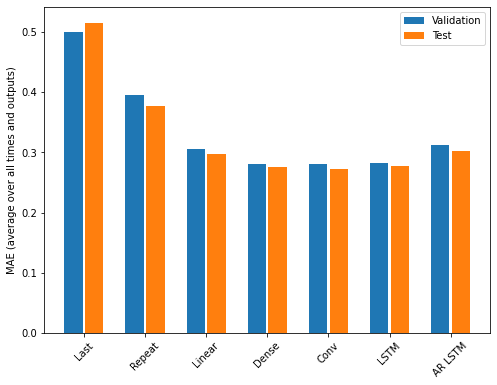

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances similar but also averaged across output timesteps. 

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2980
Dense   : 0.2754
Conv    : 0.2724
LSTM    : 0.2770
AR LSTM : 0.3026


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

* For further understanding, see:
  * Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition 
  * Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).
  * Lesson 8 of [Udacity's intro to TensorFlow for deep learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187), and the [exercise notebooks](https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning) 
* Also remember that you can implement any [classical time series model](https://otexts.com/fpp2/index.html) in TensorFlow, this tutorial just focuses on TensorFlow's built-in functionality.